#  STEAM Recommendation System

# Introduction

As part of the final project for the DS 1 we have done project on Recommendation System for game recommendation. Recommendation is used as a marketing strategy by many e-commerce companies. So our team: Abjasree S, Poojan Smart, Niranjan Solanki and Vaishnav Panuganti started working on game recommendation based on the methods which were taught in this course. 

The first part of the project is to scrape the game data as well as the user data from the websites provided below. There is an inbuilt API for steam but to use the API we have to purchase the products worth 5$ to use the API hence we tried scrapping through brute-force way.

**Data Resources:** \
We will use game data obtained from the STEAM website given below \
The data: https://store.steampowered.com/ \
We will use the user data obtained from the website given below \
The user data:  https://steamcommunity.com/games/steam/members \


**Problem Statement (Exploration):** \
The problem was divided into 3 parts which has been taught in the course
1. Scrape the data necessary for building the model and clean it
2. Build recommendation system for recommending games
3. Visualizing whether there are any clusters so that we can say that recommendation system can indeed be used. 

# Scraping Data
- Scraping the data was a very tedious and important part of this project 
- The scraping took so many days 
- Importing the necessary libraries for scrapping

In [ ]:
import json
import requests
from bs4 import BeautifulSoup
import numpy as np
import time
import pandas as pd
import re
import time
import pickle
from IPython.display import clear_output
import urllib
from threading import Thread


import numpy as np
import time
import pandas as pd
import time
import pickle
from IPython.display import clear_output
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from numpy import count_nonzero
from prettytable import PrettyTable
from scipy.sparse import csr_matrix, csc_matrix
from scipy import sparse
import math
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import shuffle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from prettytable import PrettyTable
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
import random
from sklearn.model_selection import train_test_split, cross_validate, KFold

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Activation
from tensorflow.keras import Model, models

from sklearn.decomposition import PCA
import plotly.express as px

## Games

### Scraping top-rated games from each genre

In [ ]:
games_list = []
generes = ["rpg","action","adventure_and_casual","strategy","simulation","sports_and_racing"]

In [ ]:
for genere in generes:
    start = 0
    print(genere)
    while(True):
        try:
            resp = json.loads(requests.get('https://store.steampowered.com/contenthub/querypaginated/category/TopRated/render/?query=&start='+str(start)+'&count=15&cc=IN&l=english&v=4&tag=&category='+genere).content.decode())
            soup = BeautifulSoup(resp["results_html"], 'html.parser')
            for a in soup.find_all('a'):
                game = {}
                game["game_link"] = a.get('href')
                data = a.text.strip('\n').replace("\n","|").split('|')
                game["price"] = data[0]
                game["title"] = data[1]
                game["tags"] = data[3]
                game["genere"] = genere
                games_list.append(game)
            start += resp["pagesize"]
            print(start/resp["total_count"])
            if start >= resp["total_count"]:
                break
        except:
            pass

In [ ]:
pd.DataFrame(games_list).to_csv("C:\\Users\\Administrator\\Desktop\\AI\\Univ.ai\\DS-1\\Project\\games.csv")

In [ ]:
gamesdf = pd.DataFrame(games_list).drop_duplicates(subset=['title'])
gamesdf["game_link"] = gamesdf["game_link"].apply(lambda x: x.split('?')[0])

In [ ]:
gamesdf.to_csv("C:\\Users\\Administrator\\Desktop\\AI\\Univ.ai\\DS-1\\Project\\games.csv")

### Getting user profiles from each game's review section

In [ ]:
gamesdf = pd.read_csv('games.csv').drop(["Unnamed: 0"],axis=1)

In [ ]:
gamesdf.head()

,game_link,price,title,tags,genere
0,https://store.steampowered.com/app/292030/The_...,₹ 800,The Witcher® 3: Wild Hunt,"Open World, RPG, Story Rich, Atmospheric",rpg
1,https://store.steampowered.com/app/435150/Divi...,₹ 989,Divinity: Original Sin 2 - Definitive Edition,"Tactical RPG, Turn-Based Strategy, RPG, Explo...",rpg
2,https://store.steampowered.com/app/413150/Star...,₹ 479,Stardew Valley,"Farming Sim, Life Sim, Pixel Graphics, RPG",rpg
3,https://store.steampowered.com/app/230410/Warf...,Free to Play,Warframe,"Free to Play, Action RPG, RPG, Action",rpg
4,https://store.steampowered.com/app/1085660/Des...,Free To Play,Destiny 2,"Free to Play, Open World, Looter Shooter, FPS",rpg


In [ ]:
games_user = []
count = 0
excepted_games = []

In [ ]:
for game in gamesdf['game_link']:
    try:
        print(game)
        profiles = game_reviews(game)
        for p in profiles:
            pobj = {"game":game,"profile":p,"type":"positive"}
            games_user.append(pobj)
        count += 1
        if count % 10:
            pd.DataFrame(games_user).to_csv("games_user2.csv")
    except:
        excepted_games.append(game)

In [ ]:
for game in excepted_games:
    try:
        print(game)
        profiles = game_reviews(game)
        for p in profiles:
            pobj = {"game":game,"profile":p,"type":"positive"}
            games_user.append(pobj)
        count += 1
        if count % 10:
            pd.DataFrame(games_user).to_csv("games_user2.csv")
    except:
        excepted_games.append(game)

In [ ]:
def game_reviews(gamelink):
    profiles = []
    gamelink = 'https://steamcommunity.com/app/'+gamelink.split('/')[4]+'/positivereviews/?browsefilter=toprated&snr=1_5_100010_'
    resp = requests.get(gamelink)
    page = resp.content.decode()
    soup = BeautifulSoup(page, 'html.parser')
    while len(profiles) < 20:
        profiles.extend(getprofiles(soup))
        soup = makeurl(soup)
    return profiles

def getprofiles(soup):
    profiles = []
    for div in soup.find_all('div', attrs={"class":"apphub_friend_block_container"}):
        profiles.append(div.find('a').get('href'))
    return profiles

def makeurl(soup):
    base = soup.find('form').get('action')
    base += "?"
    for inp in soup.find('form').find_all('input'):
        base += inp.get('name')+"="+urllib.parse.quote(inp.get('value'), safe='')+"&"
    base = base[:-1]
    resp = requests.get(base).content.decode()
    soup2 = BeautifulSoup(resp, 'html.parser')
    return soup2

## Users

### Getting user-specific data of all the users

In [ ]:
users = pd.read_csv('games_user2.csv').sample(frac=1)

In [ ]:
users = users['profile'].drop_duplicates()

In [ ]:
count = 0
total = 0
user_games = []
try:
    users_done = list(pd.read_csv('./data/users_done(again).csv')['users_done'].values)
except:
    users_done = []
def save_obj(obj,user):
    for i,e in enumerate(obj):
        x = {}
        x["user"] = user
        x["appid"] = e["appid"]
        if 'hours_forever' in list(e.keys()):
            x['hours_forever'] = e["hours_forever"]
        if 'last_played' in list(e.keys()):
            x['last_played'] = e["last_played"]
        x['name'] = e['name']
        
        user_games.append(x)
    users_done.append(user)

In [ ]:
file_cnt = 0
filename = "./data/user_games_again_" + str(file_cnt) + ".csv"
f = open(filename, "w")
f.close()
file_empt = True
count_came = []

In [ ]:
for user in users:
    if user in users_done:
        continue
    try:
        resp = requests.get(user + '/games/?tab=all' , proxies={"http":"socks5://127.0.0.1:9050","https":"socks5://127.0.0.1:9050"}).content.decode()
        soup = BeautifulSoup(resp, 'html.parser')
        soup.find_all('script')[-1]
        txt = soup.find_all('script')[-1].text
        found = re.search('var rgGames = (.+?);', txt).group(1)
        obj = json.loads(found)
        if obj:
            new_thread = Thread(target=save_obj,args=(obj,user))
            new_thread.start()
            count += 1
        clear_output(wait=True)
        print(count)
        #print(obj)
    except:
        print('e')
    #time.sleep(1)
    total += 0
    
    if count % 1000 == 0 and count != 0 and (count not in count_came):
        file_cnt += 1
        filename = "./data/user_games_again_" + str(file_cnt) + ".csv"
        f = open(filename, "w")
        f.close()
        count_came.append(count)
        print(filename)
        file_empt = True
        user_games = []
    
    if count % 50 == 0:
        print(count)
        if not file_empt:
            pd.concat([pd.read_csv(filename),pd.DataFrame(user_games)], axis = 0).to_csv(filename,index=False)
            user_games = []
        else:
            pd.DataFrame(user_games).to_csv(filename,index=False)
        pd.DataFrame({"users_done":users_done}).to_csv('./data/users_done(again).csv',index=False)

10046


In [ ]:
final_df = pd.DataFrame()
for i in range(0,10):
    if i == 0:
        final_df = pd.read_csv('./data/user_games_again_'+str(i)+'.csv')
    else:
        final_df = pd.concat([final_df, pd.read_csv('./data/user_games_again_'+str(i)+'.csv')], axis = 0)

In [ ]:
final_df = final_df.drop_duplicates()

In [ ]:
final_df.to_csv('all_users_games(again)2.csv')

**About Scrapped Data**

- Here we have saved two files:
   - games.csv contains the games data with details about the game
   - final_users_game.csv contains the data of user, gameid and hours he/she played that game
We will be using this for building the recommendation system

# Exploratory data analysis

- We are loading the datasets here

In [ ]:
users_game = pd.read_csv('./data/final_users_game.csv', index_col=0)
games = pd.read_csv('./data/games.csv')

## Pre-processing
- The first step in the cleaning the data is to make the data into right datatypes
- We have used apply() function to change as it is needed and made the different columns in both the dataframes

In [ ]:
users_game.dtypes

user              object
appid              int64
hours_forever    float64
dtype: object

In [ ]:
users_game['hours_forever'].unique()

array([ 1466.,  1434.,   674., ..., 12065.,  9983.,  3548.])

- Getting the hours to float values since it was string before

In [ ]:
users_game['hours_forever'] = users_game['hours_forever'].apply(lambda x: float(x.replace(",","")) if (type(x)==str) else x)

- Dropping the duplicates

In [ ]:
users_game = users_game.drop_duplicates(subset=['user','appid'])

In [ ]:
users_game.dtypes

user              object
appid              int64
hours_forever    float64
dtype: object

In [ ]:
games.dtypes

url                 object
title               object
genre               object
Release Date        object
tags                object
total_reviews        int64
positive_reviews     int64
negative_reviews     int64
price               object
appid                int64
dtype: object

- Getting the game id (here 'appid') from the end of the url

In [ ]:
games['appid'] = games['url'].apply(lambda x: int(x.split("/")[4]))
games = games.drop(["url"], axis=1)

- Making the dates to correct format

In [ ]:
games["release_date"] = pd.to_datetime(games["Release Date"], infer_datetime_format= True)
games = games.drop(["Release Date"], axis=1)

- Making the price to int since it was string before

In [ ]:
games.price = games.price.apply(lambda x: int(x) if (type(x)==str and x != 'Free' and x != np.nan) else x)
games['price'] = games['price'].replace({'Free':0})

In [ ]:
games.dtypes

title                       object
genre                       object
tags                        object
total_reviews                int64
positive_reviews             int64
negative_reviews             int64
price                      float64
appid                        int64
release_date        datetime64[ns]
dtype: object

- Doing one hot encoding to tag feature 

In [ ]:
tags_dummies = games.tags.apply(lambda x: ",".join([i.strip() for i in x[1:-1].replace('\'',"").replace("\"","").split(",")])).str.get_dummies(",")

In [ ]:
tags_dummies.shape, games.shape

((9032, 424), (9032, 9))

In [ ]:
games = pd.concat([games, tags_dummies], axis=1)
games = games.drop(['tags'], axis=1)

- Splitting the genre into a list since it was string before

In [ ]:
games['genre'] = games.genre.apply(lambda x:x[1:-1].split(",")[0].strip("\'") if type(x) == str else x)

- Finding the missing values and missing value percentage in both dataframe

In [ ]:
def missing_values_table(df):
     
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * mis_val / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val.rename('Missing Values'), mis_val_percent.rename('% Missing Values')], axis=1)
        mis_val_table = mis_val_table.loc[~(mis_val_table==0).all(axis=1)]
        return mis_val_table

In [ ]:
print("Games dataframe:")
miss = games[games.isnull().any()[games.isnull().any()].index].isnull().astype('int').sum()
for i in miss.index:
    print(i,"has ",miss[i]," missing values")

Games dataframe:
genre has  12  missing values
price has  434  missing values
release_date has  35  missing values


In [ ]:
missing_values_table(games)

,Missing Values,% Missing Values
genre,12,0.132861
price,434,4.805137
release_date,35,0.387511


In [ ]:
print("Users-Games dataframe:")
miss = users_game[users_game.isnull().any()[users_game.isnull().any()].index].isnull().astype('int').sum()
for i in miss.index:
missing_values_table(users)
    print(i,"has ",miss[i]," missing values")

Users-Games dataframe:
hours_forever has  4620441  missing values


In [ ]:
missing_values_table(users)

,Missing Values,% Missing Values
hours_forever,1297116,37.259305


### Removing users with < 3 games played

- We have removed the inactive users here by removing the users with < 3 games played

In [ ]:
users = list(users_game.groupby('user')['appid'].count()[users_game.groupby('user')['appid'].count() > 3].index)

In [ ]:
users_game = users_game[users_game.user.isin(users)]

### Normalizing hours_played
- Normalising the hours played for each user
- Here we divide the hours_forever with the sum for each user so that it will be normalized for each user according to his/her personality since we use it as an implicit rating

In [ ]:
users_game = users_game.sort_values(by='user').reset_index().drop(['index'], axis=1)

In [ ]:
user_hf = users_game.groupby(['user'], sort=False)['hours_forever'].sum()

In [ ]:
m_list = []
for i,c in enumerate(users_game.groupby('user', sort=False)['appid'].count().values):
    m_list.extend([user_hf[i]] * c)

In [ ]:
users_game['s'] = pd.Series(m_list)

In [ ]:
users_game['hours_forever'] = users_game['hours_forever']/users_game['s']

In [ ]:
users_game.drop(['s'], axis=1, inplace=True)

### Dealing null in hours_played

- Removing null records where for that users some values in hours_forever feature exists that aren't null and As hours_forever is in ascending order, the null values contains negligible played hours for that user therefore we can remove those

In [ ]:
users_game['user_null'] = users_game.hours_forever.isnull().groupby([users_game['user']]).transform('sum').astype(int)
users_game['total'] = users_game.appid.groupby([users_game['user']]).transform('count').astype(int)
users_game['user_null_per'] = users_game['user_null']/users_game['total']

- Removing users records that has all null hours_played for everygame. From the source, we saw that user's played games are not in order of hours_played when user_null_per is 1, therefore imputing any values might not be good idea. Also only 9% of user and 14% of total interaction data will be removed.

In [ ]:
users_game = users_game[~(users_game.hours_forever.isnull() & (users_game.user_null_per < 1))]

In [ ]:
user_rem_p = (users_game[(users_game.user_null_per == 1)].user.nunique()/ users_game.user.nunique()) * 100
print(f"Users(%) containing all null in hour_played for every game {user_rem_p:.2f}")

Users(%) containing all null in hour_played for every game 9.24


In [ ]:
rec_rem_p = (users_game[(users_game.user_null_per == 1)].shape[0]/ users_game.shape[0]) * 100
print(f"Users(%) containing all null in hour_played for every game {rec_rem_p:.2f}")

Users(%) containing all null in hour_played for every game 14.78


In [ ]:
users_game = users_game[(users_game.user_null_per != 1)]

In [ ]:
users_game.isnull().any()

user             False
appid            False
hours_forever    False
user_null        False
total            False
user_null_per    False
dtype: bool

**Cleaned Dataset:**
- We cleaned both the users dataset and games dataset
- We dropped the null values in both datasets since in games dataset it is very small and in users dataset we tried imputations but it didn't give good results
- So we dropped in both case since we have enough data even after dropping it

In [ ]:
nusers = users_game.user.nunique()
ngames = games.appid.nunique()

In [ ]:
x = PrettyTable()
x.field_names = ["Entities", "Unique Counts"]
x.add_row(["Users", nusers])
x.add_row(["Games", ngames])
print(x)

+----------+---------------+
| Entities | Unique Counts |
+----------+---------------+
|  Users   |     27894     |
|  Games   |      9032     |
+----------+---------------+


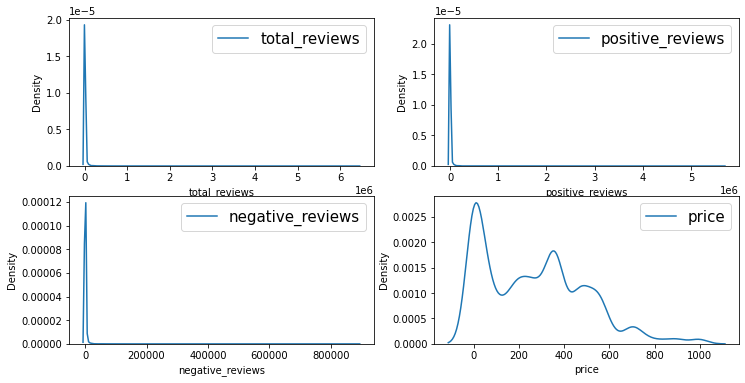

In [ ]:
plot_columns = ['total_reviews', 'positive_reviews', 'negative_reviews', 'price']
plt.figure(figsize=(12, 6))
for i in range(len(plot_columns)):
  
    plt.subplot(2,2,i+1)
    sns.kdeplot(data=games,x=plot_columns[i], label = plot_columns[i])
    
    plt.legend(fontsize=15)   
plt.show()

In [ ]:
sns.set_theme(style="darkgrid")

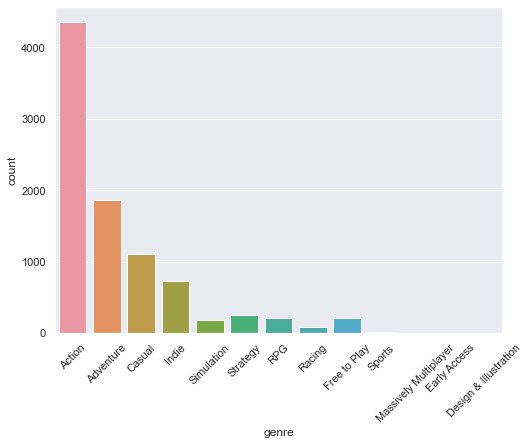

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x="genre", data=games)
plt.xticks(rotation=45)
plt.show()

**Inference:**
- Here, we can observe that the action genre is highest compared to other genres
- We have also extracted tags which is more informative than the genre(we can assume that genre is a subset of tags) so we used tags instead since it is much informative and it won't be this biased towards action genre

In [ ]:
games["year"] = games.release_date.apply(lambda x:x.year)

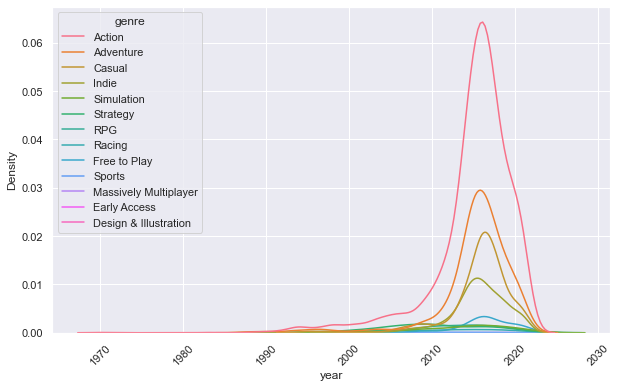

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.kdeplot(x="year", data=games[~games.isnull()], hue='genre', warn_singular=False)
plt.xticks(rotation=45)
plt.show()

**Inference:**
- We can observe that the number of almost all genre games has increased from 1970 to 2020

**Implicit Rating calculation using hours forever**
- We have also converted the hours played into the range 0-5 since we are taking it as implicit rating in some models

In [ ]:
def new_range(value, old_min, old_max):
  new_max = 5
  new_min = 0
  new_value = ( (value - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min
  return new_value

In [ ]:
users = users.sort_values(by='user').reset_index().drop(['index'], axis=1)
user_hf = users.groupby(['user'], sort=False)['hours_forever'].sum()
user_hf.head()

user
id/----JebacBarce----     1095.7
id/---Doggo---            6399.1
id/---LapkA---            1837.2
id/---player              2037.6
id/---super---           15804.7
Name: hours_forever, dtype: float64

In [ ]:
users_list = user_hf.index.tolist()

In [ ]:

final_users = pd.DataFrame()
for user in users_list:
  df = users[users['user'] == user]
  #print(df.head(2))
  hours_forever = df[['hours_forever']]
  old_min = hours_forever.values.min()
  old_max = hours_forever.values.max()
  #print(old_min)
  #print(old_max)
   
  hours_trans = hours_forever.apply(new_range, args=(old_min, old_max))
  df['rating'] = np.round(hours_trans, 5)
  
  final_users = pd.concat([final_users, df], axis=0)
  #print(final_users.head())
  


In [ ]:
final_users['rating_int'] = final_users['rating'].astype(int)
final_users.head(2)

,user,appid,hours_forever,name,rating,rating_int
0,id/----JebacBarce----,1049800,12.4,BLOCKADE,0.0000,0
1,id/----JebacBarce----,304930,15.3,Unturned,0.0207,0


Text(0.5, 1.0, 'Histogram of Hours played by each user')

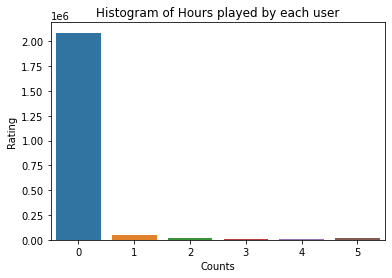

In [ ]:
sns.countplot(data=final_users, x="rating_int")

plt.xlabel('Counts')
plt.ylabel('Rating')

plt.title('Histogram of Hours played by each user')

Text(0.5, 1.0, 'Histogram of Hours played by each user')

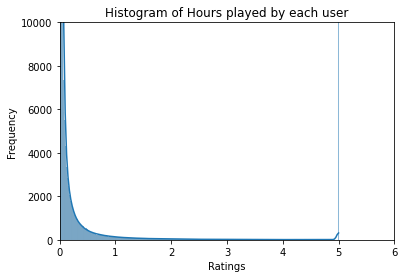

In [ ]:
sns.histplot(data=final_users, x="rating", kde=True)
plt.ylim(0, 10000)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.xlim(0, 6)
plt.title('Histogram of Hours played by each user')

**Inference:**
- From this plot we can observe that most of the hours_forever(ratings) are between 0-1 which means that the users only play much less time in games they don't like and spend alot more time in the games they actually like

In [ ]:
print("Top 10 Games played by total players.\n",'-'*60)
print(pd.merge(games, users_game.groupby('appid')['user'].count(), on='appid').sort_values(by='user', ascending=False)[:10][['title','user','genre']].to_markdown())

Top 10 Games played by total players.
 ------------------------------------------------------------
|      | title                            |   user | genre   |
|-----:|:---------------------------------|-------:|:--------|
| 2934 | Counter-Strike: Global Offensive |  20693 | Action  |
| 3930 | Team Fortress 2                  |  19718 | Action  |
| 1919 | Left 4 Dead 2                    |  17976 | Action  |
| 4522 | Garry's Mod                      |  16241 | Indie   |
| 1914 | Portal 2                         |  15734 | Action  |
| 1858 | Terraria                         |  15581 | Action  |
| 3696 | PAYDAY 2                         |  15580 | Action  |
| 2877 | Dota 2                           |  14010 | Action  |
| 1458 | Borderlands 2                    |  13133 | Action  |
| 3664 | Unturned                         |  12572 | Action  |


In [ ]:
print("Top 10 Games played by total hours.\n",'-'*60)
print(pd.merge(games, users_game.groupby('appid')['hours_forever'].sum(), on='appid').sort_values(by='hours_forever', ascending=False)[:10][['title','hours_forever','genre']].to_markdown())

Top 10 Games played by total hours.
 ------------------------------------------------------------
|      | title                            |   hours_forever | genre   |
|-----:|:---------------------------------|----------------:|:--------|
| 2934 | Counter-Strike: Global Offensive |        2977.81  | Action  |
| 3930 | Team Fortress 2                  |        1208.71  | Action  |
| 2877 | Dota 2                           |        1190.04  | Action  |
| 4522 | Garry's Mod                      |         745.871 | Indie   |
| 3567 | Grand Theft Auto V               |         518.391 | Action  |
| 1858 | Terraria                         |         447.03  | Action  |
| 1451 | Tom Clancy's Rainbow Six® Siege  |         397.926 | Action  |
| 1564 | Warframe                         |         367.089 | Action  |
| 7198 | PUBG: BATTLEGROUNDS              |         336.939 | Action  |
| 3306 | Rust                             |         317.184 | Action  |


# Models

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

- Labelencoding the users since the user name will take more space

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
users['users_labels'] = labelencoder.fit_transform(users['user'])
users.head(2)

,user,appid,hours_forever,name,rating,users_labels
0,id/----JebacBarce----,1049800,12.4,BLOCKADE,0.0000,0
1,id/----JebacBarce----,304930,15.3,Unturned,0.0207,0


- Deleting the columns which aren't needed for the model

In [ ]:
del games['title']
del games['genre']
del games['release_date']

In [ ]:
del users['user']
del users['name']
del users['hours_forever']

- Here, we are finding the top 1000 active users since the system crashes when we use all the users in some models 

In [ ]:
top1000id = list(users.groupby('users_labels')['appid'].count().sort_values(ascending=False)[:1000].index)
top1000users = users[users['users_labels'].isin(top1000id)]
top1000users.head()

,appid,rating,users_labels
1086,298600,0.00443,16
1087,556870,0.00421,16
1088,492720,0.00686,16
1089,215510,0.00465,16
1090,556280,0.00421,16


- Merging both dataframe to create final dataframe which can be used in the models

In [ ]:
finaldf = pd.merge(games, top1000users, on='appid', how = 'inner')

- Saving the final dataframe to the pickle file

In [ ]:
finaldf = finaldf.to_pickle('finaldf.pkl')

## Basic Models

### Baseline Popular Model (Predicting the mean)

In [ ]:
train_ratings, test_ratings = train_test_split(finaldf, test_size=0.2, random_state=42)
train_ratings.shape, test_ratings.shape

((522015, 431), (130504, 431))

In [ ]:
baseline_y_pred = pd.DataFrame(train_ratings.groupby('appid')['rating'].mean()).rename(columns={"rating": "Predicted rating"})

In [ ]:
baseline_y_true = pd.DataFrame({'appid': test_ratings["appid"], 'True rating': test_ratings['rating']})
baseline_model = pd.merge(baseline_y_pred, baseline_y_true, on='appid')
baseline_model.head()

,appid,Predicted rating,True rating
0,20,0.030156,0.00187
1,20,0.030156,4.91082
2,20,0.030156,0.00037
3,20,0.030156,0.00272
4,20,0.030156,0.00087


In [ ]:
print("MSE baseline model: ", mean_squared_error(baseline_model["Predicted rating"], baseline_model["True rating"]))

MSE baseline model:  0.08677594846949514


**Inference:**
- The mean square error seems to be very less for the base model
- It might be because the hours_forever is biased and a large number of it is near zero which makes the average close to zero as you can see from above 

### Collaborative Filtering Model

In [ ]:
# Creating a 2D matrix (user ID vs movie ID) with the ratings as elements
user_matrix = train_ratings.pivot(index='users_labels', columns='appid', values='rating')

# Subtract each user's average rating to magnify individual preferences
user_matrix = user_matrix.sub(user_matrix.mean(axis=1), axis=0)

# Replace NaN with 0.0, as this is now the "neutral" value
user_matrix = user_matrix.fillna(0.0)

In [ ]:
user_matrix

appid,20,30,40,50,60,70,130,220,240,300,...,1877960,1888430,1891700,1901200,1902490,1911390,1922560,1926680,1948280,1959480
users_labels,,,,,,,,,,,,,,,,,,,,,
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.009140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.742175,0.179485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006662,0.266832,0.010232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.025802,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.103128,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
16895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
17003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221009,0.0


In [ ]:
# Calculate the Pearson Correlation between each user,
# and subtract this from 1 to get the Pearson Distance between users

user_dist_matrix = 1 - user_matrix.T.corr()
user_dist_matrix

users_labels,16,39,47,59,64,66,73,79,83,124,...,16377,16445,16670,16694,16695,16800,16895,17003,17069,17212
users_labels,,,,,,,,,,,,,,,,,,,,,
16,0.000000,0.999100,1.154824,0.994327,1.000019,0.999661,0.671101,0.703507,0.994025,0.999234,...,1.010294,0.999701,0.925968,0.999759,0.373724,0.999395,0.999895,0.998444,0.074893,0.197530
39,0.999100,0.000000,1.004438,0.923039,0.764315,1.001218,0.997611,0.860554,0.920416,0.973066,...,1.005625,0.798723,1.002234,0.889537,0.658255,1.003484,0.981880,0.971358,0.999767,0.999829
47,1.154824,1.004438,0.000000,1.007122,1.008277,0.993459,1.044730,1.083244,1.004301,0.995154,...,1.001363,0.998498,1.056256,1.002636,1.132271,0.980452,0.985273,1.005648,1.122382,1.131221
59,0.994327,0.923039,1.007122,0.000000,1.002346,0.998930,0.996337,0.993222,0.969068,0.998867,...,1.004528,1.002338,0.992155,1.004776,0.997345,0.999631,0.985998,0.998340,0.995484,0.994688
64,1.000019,0.764315,1.008277,1.002346,0.000000,0.989201,1.001005,1.002837,0.796807,0.987492,...,0.998395,0.792162,0.931087,0.997036,0.990742,1.008638,1.020791,1.005024,1.001879,0.999315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16800,0.999395,1.003484,0.980452,0.999631,1.008638,0.997204,0.998569,1.004344,0.987765,0.998782,...,1.000181,1.013368,0.999017,1.007989,0.998814,0.000000,0.997606,0.897696,0.999793,1.008723
16895,0.999895,0.981880,0.985273,0.985998,1.020791,1.002528,0.966122,0.979965,1.010424,0.999006,...,1.021343,0.890248,1.010752,0.961304,0.998002,0.997606,0.000000,1.007590,0.992874,1.002829
17003,0.998444,0.971358,1.005648,0.998340,1.005024,1.000743,1.000545,0.993626,1.006543,0.999531,...,0.999726,1.007221,0.993698,1.005725,0.994046,0.897696,1.007590,0.000000,0.998461,1.002537


In [ ]:
CF_predictions = []

# For every rating in the test data
for index, row in test_ratings.iterrows():
    # If the movie is in the training data
    if row["appid"] in train_ratings["appid"].unique():
        # Extract all user ID's for users who have rated the movie
        users_rated_movie = train_ratings.loc[train_ratings['appid'] == row['appid'], 'users_labels'] #1,2,3
        # Sort these users by similarity (Pearson distance)
        users_sorted = (user_dist_matrix.loc[row['users_labels'], users_rated_movie].sort_values()) #691
        # Select the nearest neighbours
        nearest_neighbours = users_sorted[:5] # 5 nearest neighbours
        # Extract the nearest neighbours' ratings data
        nn_data = train_ratings.loc[train_ratings['users_labels'].isin(nearest_neighbours.index.to_list())]
        # Calculate the weighted average of the nearest neighbours' ratings
        nearest_neighbours_avg_rating = np.average(nn_data.loc[train_ratings['appid'] == row['appid'], 'rating'],axis=0, weights=(1/nearest_neighbours))
   

    CF_predictions.append(nearest_neighbours_avg_rating)

print(mean_squared_error(test_ratings['rating'], CF_predictions))

0.09569282225767287


**Inference:**
- The mean squared error here is 0.09569
- Here, also we can observe that the mean square error is very less 
- We can clearly see that we need a metrics to evaluate the recommendation system

### Simple Content Based Model


In [ ]:
RMSE_CBF_listed = []
games_df_noid = games.drop(['appid'], axis = 1)
CBF_predictions = []

# For each user in the training dataset:
for user in train_ratings['users_labels'].unique():
    model=Ridge(alpha=100,fit_intercept=True,normalize=True, max_iter=3000,tol=0.001,solver='lsqr',random_state=42,)
    model.fit(train_ratings[train_ratings['users_labels']==user].iloc[:,3:], train_ratings[train_ratings['users_labels']==user]['rating'])
    prediction = model.predict(games_df_noid)
    prediction = np.clip(prediction, 0, 5)  
    CBF_predictions.append(prediction)

df_predict = pd.DataFrame(CBF_predictions, index=train_ratings['users_labels'].unique(), columns=games['appid'].unique())

In [ ]:
CBF_predictions = []
for index, row in test_ratings.iterrows():
    user_predictions = df_predict.loc[row["users_labels"], row["appid"]]
    CBF_predictions.append(user_predictions)

print(mean_squared_error(test_ratings['rating'], CBF_predictions))

0.2694954311097876


**Inference:**
- Here, we are fitting a model for each user and the data for each user is between 1000-2000
- We can observe that the mean squared error is increasing here
- In this model we are predicting based on the content not the user-user or user-item relationship
- Since the model is considering other factors to predict the behavior it is getting error 

### Hybrid Model (Basic)
$predictions = \frac{1}{2}(CBF(prediction)+ CF(prediction))$

In [ ]:
combined_predictions = np.array([y_pred * 0.5 for y_pred in np.array(CBF_predictions)]) + np.array([y_pred * 0.5 for y_pred in np.array(CF_predictions)])
print(f"MSE for combined approach with CBF and CF: {mean_squared_error(test_ratings['rating'], combined_predictions)}")

MSE for combined approach with CBF and CF: 0.13011461653866163


**Inference:**
- Here, taking average of CBF and CF
- So, it is smalled than CBF and larger than the CF 

### User-User Model

**Loading data**

In [ ]:
users_game = pd.read_csv('./data/process_users_games.csv', index_col=0)
games = pd.read_csv('./data/process_games.csv', index_col=0)

In [ ]:
#csc = sparse.load_npz('./data/csc.npz')
csr = sparse.load_npz('./data/csr.npz')

In [ ]:
nusers = csr.shape[0]
ngames = csr.shape[1]

Calculating consine-similarity matrix

In [ ]:
similarities_sparse = cosine_similarity(csr,dense_output=False)

**Evaluation**

Predict whole user-user matrix based on n-neighbours

In [ ]:
n = [3,5,7,10,15]

In [ ]:
n_mse = []
n_hitrate = []

In [ ]:
n = [3,5,7,10,15]
n_mse = []
n_hitrate = []
for negh in n:
    pred = np.zeros(shape=(nusers,ngames))
    iters = {}
    for user in range(0,nusers):
        p = list(np.argsort(similarities_sparse.getrow(user).toarray()[0])[::-1][:negh])
        n_vectors = np.zeros(shape=(negh,ngames))
        if user in p:
            p.remove(user)
        for i,neighbour in enumerate(p):
            n_vectors[i] = csr.getrow(neighbour).toarray()[0]
        
        pred[user] = n_vectors.mean(axis=0)
        
        played = set(list(np.argsort(csr.getrow(user).toarray()[0])[::-1][:10]))
        recom = set(list(np.argsort(pred[user])[::-1][:10]))
        hitrate = len(played.intersection(recom))/len(played)
        iters[user] = hitrate
    n_hitrate.append(iters)
    n_mse.append(np.mean((csr.toarray() -  pred)**2))
    

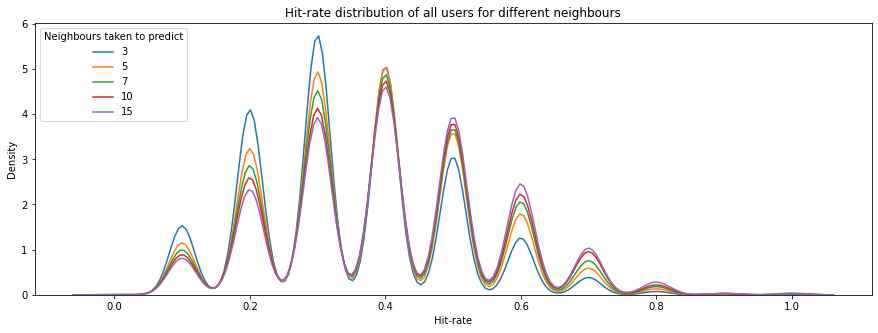

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Hit-rate distribution of all users for different neighbours")
for i in n_hitrate:
    sns.kdeplot(i.values())
plt.xlabel("Hit-rate")
plt.legend(title='Neighbours taken to predict', loc='upper left', labels=n)
plt.show()

In [ ]:
n_hitrate_by_user = np.zeros(shape=(nusers))
for hrate in n_hitrate:
    n_hitrate_by_user += list(hrate.values())
n_hitrate_by_user = n_hitrate_by_user/5

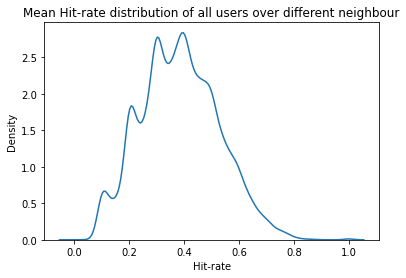

In [ ]:
sns.kdeplot(n_hitrate_by_user)
plt.title("Mean Hit-rate distribution of all users over different neighbour")
plt.xlabel("Hit-rate")
plt.show()

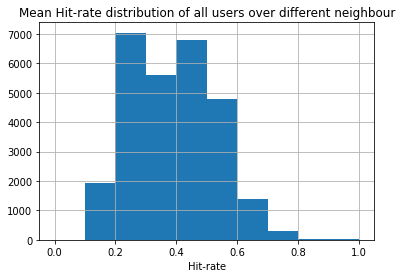

In [ ]:
pd.Series(n_hitrate_by_user).hist()
plt.title("Mean Hit-rate distribution of all users over different neighbour")
plt.xlabel("Hit-rate")
plt.show()

In [ ]:
n_hitrate_by_neigh = []
for hrate in n_hitrate:
    n_hitrate_by_neigh.append(np.mean(list(hrate.values())))

In [ ]:
ptab = PrettyTable()
ptab.field_names = ["N-Neighbours", "Mean Hit-rate", "MSE"]
for i,n_ in enumerate(n):
    a = f"{n_hitrate_by_neigh[i]:.3f}"
    b = f"{n_mse[i]:.7f}"
    
    ptab.add_row([n_, a, b])
print(ptab)

+--------------+---------------+-----------+
| N-Neighbours | Mean Hit-rate |    MSE    |
+--------------+---------------+-----------+
|      3       |     0.347     | 0.0000045 |
|      5       |     0.375     | 0.0000047 |
|      7       |     0.389     | 0.0000051 |
|      10      |     0.401     | 0.0000056 |
|      15      |     0.412     | 0.0000062 |
+--------------+---------------+-----------+


In [ ]:
def get_recom(user, sim, csr, neighbours = 5, games = 5):
    user_g = get_ugames(user, users_game)
    rec = []
    nearest_users = np.argsort(sim.getrow(user).toarray()[0])[(-1-neighbours):-1]
    s = None
    for user in nearest_users:
        csr.getrow(user).toarray()
        if type(s)==type(None):
            s = csr.getrow(user).toarray()
        else:
            s += csr.getrow(user).toarray()
    for g in s[0].argsort()[::-1]:
        if g in user_g:
            continue
        if len(rec) == games:
            return rec
        else:
            rec.append(g)
    return rec

def get_ugames(user, users_game):
    return users_game[users_game.user == user].appid.values

**Inference**

In [ ]:
rand_user = np.random.randint(0, nusers, size = 5)

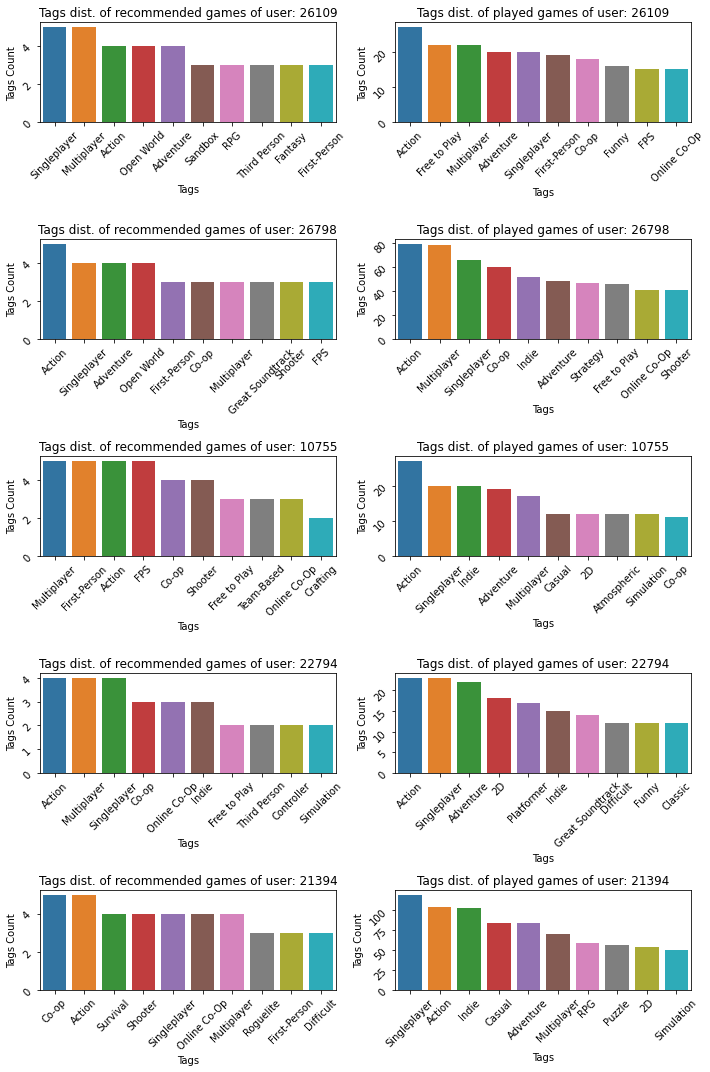

In [ ]:
rand_user = np.random.randint(0, nusers, size = 5)
f,axs = plt.subplots(5,2, figsize=(10,15))
plt.title("ff")

for i,user in enumerate(rand_user):
    recom_games = get_recom(user, similarities_sparse, csr, 5, 5)
    played_games = get_ugames(user, users_game)
    
    dist1 = games[games['appid'].isin(recom_games)].iloc[:,8:-1].sum(axis=0)
    top10tags1 = pd.DataFrame(dist1).reset_index().sort_values(by=0, ascending=False)[:10]
    
    dist2 = games[games['appid'].isin(played_games)].iloc[:,8:-1].sum(axis=0)
    top10tags2 = pd.DataFrame(dist2).reset_index().sort_values(by=0, ascending=False)[:10]
    
    
    axs[i][0].tick_params(labelrotation=45)
    ax = sns.barplot(x = top10tags1['index'], y = top10tags1[0], ax = axs[i][0])
    ax.set_xlabel("Tags")
    ax.set_ylabel("Tags Count")
    ax.title.set_text('Tags dist. of recommended games of user: '+str(user))
    
    axs[i][1].tick_params(labelrotation=45)
    ax = sns.barplot(x = top10tags2['index'], y = top10tags2[0], ax = axs[i][1])
    ax.set_xlabel("Tags")
    ax.set_ylabel("Tags Count")
    ax.title.set_text('Tags dist. of played games of user: '+str(user))
plt.tight_layout()

## Complex Models

### Item-Item Collaborative filtering:
-  First we converted the original user-item Dataframe to pivot table to calculate the cosine similarity and centered cosine similarity. 

In [ ]:
## To Convert the Dataframe into pivot table
df2 = users_game.copy()
df2.user = df2.user.astype('object')
df2.appid = df2.appid.astype('object')
df2 = df2.drop(['user_null','total','user_null_per'],axis=1)

pvt = df2.pivot_table(index='user',columns='appid',values='hours_forever')
pvt = pvt.fillna(0)
pvt.head()

#### 1. Item Item Collaborative filtering based on Cosine Similarity:
- <b>Base model:</b> In Base model we simply calculated the Cosine Similarity between the 'appid' and filtered the recommendation of 'appid' which have been rated by more than 1000 users.

In [ ]:
## Games which are correlated with the game '9000' using Simple correlation 
## only recommending those games which are rated by more than 1000 users.

similar_9000 = pvt.corrwith(pvt1[9000])
corr_9000_df = pd.DataFrame(similar_9000,columns=['correlation'])
corr_9000_df.dropna(inplace=True)
no_ratings = df2.groupby('appid').count()['user']
corr_9000 = corr_9000_df.abs().sort_values(by='correlation',ascending=False)
corr_9000 =  corr_9000.join(no_ratings)

## only which have ratings more than 1000 and correlated with appid 9000
corr_9000[corr_9000.user>1000].head(10)

#### 2. Item Item Collaborative filtering using Centered Cosine Similarity with Weighted average.
- first we converted the pivot table dataframe to centerd cosine for each item.
- we calculate the similarity between the items which are rated by user 'u' and get the top 'n' similar items and based on these items we calculate the rating using weighted average of the particular item 'i'.

In [ ]:
from scipy.sparse import csr_matrix

### function to calculate Centered Cosine for an array
### parameter - x (ndarray)
def ccs(x):
    x = np.array(x,dtype='float')
    mean = x[list(csr_matrix(x).nonzero()[1])].mean()
    idx = csr_matrix(x).nonzero()[1]
    for z in idx:
        x[z] = x[z]-mean        
    return x


## to convert the dataframe into the Centered Cosine using above function
ccs_df = pvt.copy()

for i in range(len(ccs_df)):
    arr_row = np.array(ccs_df.loc[i])
    ccs_df.loc[i] = ccs(arr_row)
    
ccs_df.shape, pvt.shape

In [ ]:
## To get the ratings of unknown rating using item item similarity
### PARAMETERS ###
## x = appid
## u = userid
## n = ratings will be calculated based on top 'n' recommendations 


def getrec(x, u, n):
    x = str(x)
    ans = ccs_df[x].loc[u]
    
    ## getting the array of ratings of the user u
    b = np.array(ccs_df.loc[u])
    ## find games which have rated by the user u
    it = np.nonzero(b)
    ## columns in ccs_df
    cols = np.array(ccs_df.columns)[it]
    
    ## calculating the similarity between the these cols and item x
    ## getting array of item x
    item = np.array(ccs_df[x])
    sim_dict = dict()
    for i in cols:
        a = np.array(ccs_df[i])
        sim = np.abs(np.corrcoef(a,item)[1,0])
        sim_dict[i]=sim
    
    ## getting top 20 ratings
    sim_df = pd.Series(sim_dict).sort_values(ascending=False).head(20)
    
    ## Calculation of rating from similar items
    den = sim_df.sum()
    num = 0
    for i in sim_df.index:
        num+=sim_df[i]*ccs_df[i].loc[u]
    
    rating = num/den
    
    return rating  


In [ ]:
## for user 'u' based on top 'n' similar ratings
## To compare the ratings from original one for userid '7'
## Based on top 20 Similar Ratings
def inference_(u, n):
  idx = ccs_df.loc[u][ccs_df.loc[u]!=0].index
  true, pred = [], []
  for j, i in enumerate(idx):
    true.append(ccs_df.loc[u][ccs_df.loc[u]!=0][j]), pred.append(getrec(int(i),0,n))    
    print("True ", ccs_df.loc[u][ccs_df.loc[u]!=0][j],"Pred ",getrec(int(i),0,n),"\n")  
  return true, pred

## for user 7 according to top 20 ratings
print('MSE : ', mean_squared_error(inference_(7, 20)))

MSE :  0.005052493761712706


### User Centric Recommendation System
- Here, we have only done for top 1000 active users since it will take alot of time and system crashes

In [ ]:
X  = finaldf.drop(['hours_forever', 'appid'], axis = 1)

In [ ]:
y = finaldf[['hours_forever']]

In [ ]:
trainx, testx, trainy, testy = train_test_split(X,y, train_size=0.8,random_state = 22)

In [ ]:
## scaling the numerical values using Standard scalar.
cols = ['total_reviews', 'positive_reviews', 'negative_reviews', 'price', 'year']
scaler = StandardScaler()
scaler.fit(trainx[cols])
trainx[cols] = scaler.transform(trainx[cols])
testx[cols] = scaler.transform(testx[cols])

In [ ]:
trainy= pd.DataFrame(trainy)
testy = pd.DataFrame(testy)
top1000id = pd.unique(X.users_labels)
print(len(top1000id))

- Here, we are finding the best classifier for each user using GridSearchCV and fitting with the best model

In [ ]:
def best_classifier(model, param, X,y, scoring = 'neg_mean_absolute_error'):
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    gs = GridSearchCV(model, param, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
    gs.fit(X,y)
    print(f"BEST score {round(gs.best_score_,2)}")
    best = gs.best_params_
    return best

In [ ]:
## creating dictionaries to store different models for users.
lass_user_model = {}
ridge_user_model = {}
rf_user_model = {}
lr_user_model = {}

## Creating dictionaries to store the test MSEs.
lass_test_score = {}
ridge_test_score = {}
rf_test_score = {}
lr_test_score = {}

## Loop to go through all the users.
training_error, validation_error = [],[]
for user in top100id:
    ## Creating x and y training variables
    user_x = trainx[trainx['users_labels'] == user].drop(['users_labels'], axis=1)
    user_y = trainy[trainx['users_labels'] == user]
    #print(len(user_x))
    #print(len(user_y))
    
    #print(np.mean(user_y))
    
    ## Create the test variables.
    user_testx = testx[testx['users_labels']==user].drop(['users_labels'], axis=1)
    user_testy = testy[testx['users_labels']==user]
   
    
   
    #Ridge
    
   
    ridge_model = Ridge(alpha=100,fit_intercept=True,normalize=False,copy_X=True,max_iter=3000,tol=0.001,solver='lsqr',random_state=42,)
     
    
    best = best_classifier(ridge_model, param, user_x, user_y, scoring ='neg_mean_absolute_error')
    #print(best)
    
    ridge_model_best = Ridge(alpha=best['alpha'],fit_intercept=best['fit_intercept'],normalize=best['normalize'],copy_X=True,max_iter=None,tol=0.001,solver=best['solver'],random_state=42,)
    ridge_model_best.fit(user_x, user_y)
    
    ridge_test_pred = ridge_model_best.predict(user_testx)
    
    ridge_test_err = mean_squared_error(ridge_test_pred, user_testy)    
    
    ridge_user_model[user] = ridge_model_best
    ridge_test_score[user] = ridge_test_err
    #print(ridge_model.coef_)
    #coef = ridge_model_best.coef_
    
    rf_model = RandomForestRegressor()
    param_grid = {  'bootstrap': [True], 'max_depth': [2, 3, 4, 5, 6, 7, 8], 'max_features': ['auto', 'log2'], 'n_estimators': [10, 20, 30, 50, 80, 100, 150]}
    best = best_classifier(rf_model, param_grid, user_x, user_y, scoring ='neg_mean_absolute_error')
    rf_model = RandomForestRegressor(n_estimators=best['n_estimators'], max_depth=best['max_depth'], max_features=best['max_features'], bootstrap = best['bootstrap'])
    rf_model.fit(user_x, user_y)
    
    rf_test_pred = rf_model.predict(user_testx)
    rf_test_err = mean_squared_error(rf_test_pred, user_testy)
        
    rf_user_model[user] = rf_model
    rf_test_score[user] = rf_test_err
    

In [ ]:
pt = PrettyTable()
pt.field_names = ["Model","Mean of MSEs","Standard Deviation"]

pt.add_row(['Ridge',round(np.mean(list(ridge_test_score.values())),4), round(np.std(list(ridge_test_score.values())),4)])

pt.add_row(['Random Forest',round(np.mean(list(rf_test_score.values())),4), round(np.std(list(rf_test_score.values())),4)])
print(pt)

+---------------+--------------+--------------------+
|     Model     | Mean of MSEs | Standard Deviation |
+---------------+--------------+--------------------+
|     Ridge     |    0.121     |       0.1633       |
| Random Forest |    0.1201    |       0.1447       |
+---------------+--------------+--------------------+


- Finding the top 5 predictions by the model

In [ ]:
feats = games.drop(['title', 'genre', 'appid', 'release_date'], axis = 1)
cols = ['total_reviews', 'positive_reviews', 'negative_reviews', 'price', 'year']
feats[cols] = scaler.transform(feats[cols])

In [ ]:
def get_recommendation(userid, recep):
    pred = rf_user_model[userid].predict(recep)
    print(pred)
    print(max(pred))
    top5rec = games.iloc[np.argsort(pred)[::-1][:5],:]
    return top5rec

In [ ]:
user = top1000id[np.random.randint(0,1000)]
get_recommendation(user, feats)

[0.07839753 0.03462955 0.08132776 ... 0.05702326 0.03382961 0.0337856 ]
3.2291430444478584


,title,genre,total_reviews,positive_reviews,negative_reviews,price,appid,release_date,1980s,1990s,...,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports,year
3930,Team Fortress 2,Action,867764,811855,55909,0.0,440,2007-10-10,0,0,...,0,0,0,0,0,0,0,0,0,2007
1451,Tom Clancy's Rainbow Six® Siege,Action,1054787,918733,136054,999.0,359550,2015-12-01,0,0,...,0,0,0,0,0,0,0,0,0,2015
153,SUPERHOT VR,Action,7945,5869,2076,599.0,617830,2017-05-25,0,0,...,0,0,0,0,0,0,0,0,0,2017
162,Titanfall® 2,Action,114007,107801,6206,315.0,1237970,2016-10-28,0,0,...,0,0,0,0,0,0,0,0,0,2016
3455,Plants vs. Zombies™ Garden Warfare 2: Deluxe E...,Action,2605,2277,328,315.0,1922560,2022-05-16,0,0,...,0,0,0,0,0,0,0,1,0,2022


In [ ]:
user = top1000id[np.random.randint(0,100)]
get_recommendation(user, feats)

[0.24572313 0.11149597 0.11805883 ... 0.09443378 0.08495393 0.08577106]
1.4549796933983306


,title,genre,total_reviews,positive_reviews,negative_reviews,price,appid,release_date,1980s,1990s,...,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports,year
2640,Oxygen Not Included,Indie,83292,80344,2948,569.0,457140,2019-07-30,0,0,...,0,0,0,0,0,0,0,0,0,2019
135,Farm Together,Casual,16880,15891,989,529.0,673950,2018-10-11,0,0,...,0,0,0,0,0,0,0,0,0,2018
5581,Cyberpunk 2077,RPG,515718,386459,129259,2.0,1091500,2020-12-09,0,0,...,0,0,0,0,0,0,0,0,0,2020
1116,Fall Guys: Ultimate Knockout,Action,438316,357216,81100,529.0,1097150,2020-08-03,0,0,...,0,0,0,0,0,0,0,0,0,2020
1891,Planet Zoo,Casual,56586,51005,5581,2.0,703080,2019-11-05,0,0,...,0,0,0,0,0,0,0,0,0,2019


**Inference:**
- Here, we can observe the top 5 recommendations for each user 
- From the above examples we can observe that even though action is most occuring genre we can see that recommendation for each user is based on user
- We can also observe that even though we haven't passed the genre as the parameter to the model the predictions genre of a user seems to be connected

### Collaborative Filtering (Matrix Factorization/Embedding)

In [ ]:
users_game = pd.read_csv('./data/process_users_games.csv', index_col=0)
games = pd.read_csv('./data/process_games.csv', index_col=0)

In [ ]:
users_game = users_game.sample(frac=1, random_state=20)

In [ ]:
X = users_game[['user','appid']]
y = users_game['hours_forever']
train_x,test_x, train_y,test_y = train_test_split(X, y, train_size=0.80)
train_x,val_x, train_y,val_y = train_test_split(train_x, train_y, train_size=0.75)

In [ ]:
ngames = games.appid.nunique()
nusers = users_game.user.nunique()

In [ ]:
input_user = Input(shape=(1))
emb_user = Embedding(nusers, 25, input_length = 1)(input_user)

input_games = Input(shape=(1))
emb_games = Embedding(ngames, 25, input_length = 1)(input_games)

dot = Dot(axes = (2,2))([emb_user, emb_games])
op = Activation('sigmoid')(dot)

In [ ]:
model = Model(inputs = [input_user,input_games], outputs = op)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['binary_crossentropy','mean_squared_error'], )

In [ ]:
history = model.fit([train_x['user'],train_x['appid']], train_y, epochs=1, validation_data = [val_x['user'], val_y['appid']])

In [ ]:
model.evaluate([test_x['user'],test_x['appid']], test_y)

33786/33786 [==============================] - 74s 2ms/step - loss: 0.0260 - binary_crossentropy: 0.0260 - mean_squared_error: 5.5917e-04


[0.026006950065493584, 0.026006950065493584, 0.0005591668887063861]

In [ ]:
model.save('./data/my_model')

INFO:tensorflow:Assets written to: ./data/my_model\assets


In [ ]:
model = models.load_model('./data/my_model')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 25)        697350      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 25)        225800      input_4[0][0]                    
____________________________________________________________________________________________

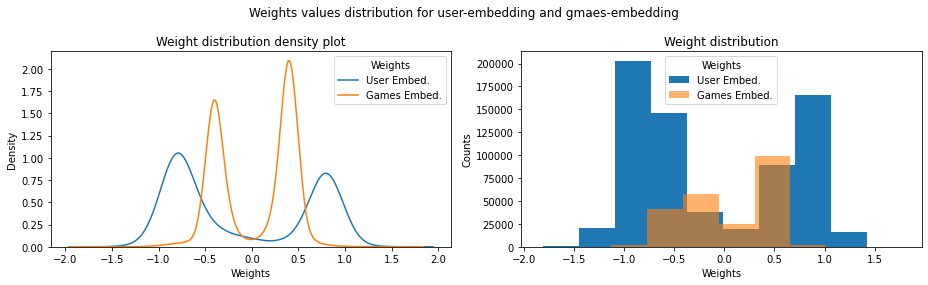

In [ ]:

f,ax = plt.subplots(1,2, figsize=(13,4))
f.suptitle('Weights values distribution for user-embedding and gmaes-embedding')
sns.kdeplot(model.weights[0].numpy().reshape(1,-1)[0], ax = ax[0])
sns.kdeplot(model.weights[1].numpy().reshape(1,-1)[0], ax = ax[0])
ax[0].legend(title='Weights', labels=["User Embed.", "Games Embed."])
ax[0].set_xlabel("Weights")
ax[0].set_title("Weight distribution density plot")

ax[1].hist(model.weights[0].numpy().reshape(1,-1)[0])
ax[1].hist(model.weights[1].numpy().reshape(1,-1)[0], alpha=0.6)
ax[1].legend(title='Weights', labels=["User Embed.", "Games Embed."])
ax[1].set_xlabel("Weights")
ax[1].set_ylabel("Counts")
ax[1].set_title("Weight distribution")
plt.tight_layout()
plt.show()

**Hit-rate Calculation**

Hit-rate calculated on only test-set predictions taking in the top 10 ranking

In [ ]:
top = 10
histories = []
n_fold = []
kf = KFold(n_splits=4)
for train_index, test_index in kf.split(X):
    intr = {}
    cmodel = models.clone_model(model) 
    cmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['binary_crossentropy','mean_squared_error'], )
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    history = cmodel.fit([X_train['user'],X_train['appid']], y_train, epochs=1, validation_data = ([X_test['user'], X_test['appid']], y_test))
    
    p = cmodel.predict([X_test['user'],X_test['appid']])
    p = pd.Series(p.reshape(p.shape[0],), name="pred")
    temp = pd.concat([X_test.reset_index().drop(['index'],axis=1),p], axis=1)
    temp = pd.concat([temp,y_test.reset_index().drop(['index'],axis=1)], axis=1)
    for user in temp.user.unique():
        s1 = temp[temp.user == user].sort_values(by='hours_forever', ascending=False)[:top].appid
        s2 =temp[temp.user == user].sort_values(by='pred', ascending=False)[:top].appid
        s1 = set(s1.values)
        s2 = set(s2.values)
        hit_rate = len(s1.intersection(s2))/len(s1)
        intr[user] = hit_rate
    n_fold.append(intr)
    histories.append(history)

126695/126695 [==============================] - 742s 6ms/step - loss: 0.0760 - binary_crossentropy: 0.0760 - mean_squared_error: 0.0166 - val_loss: 0.0268 - val_binary_crossentropy: 0.0268 - val_mean_squared_error: 7.0109e-04


In [ ]:
hitrate_user = {}
hitrate_user_perfold = []

for f in n_fold:
    for u in f.keys():
        if u in hitrate_user.keys():
            hitrate_user[u] = (hitrate_user[u] + f[u]) / 2
        else:
            hitrate_user[u] = f[u]
    hitrate_user_perfold.append(np.mean(list(f.values())))
hitrate_user = pd.DataFrame({"user":hitrate_user.keys(), "hitrate":hitrate_user.values()})

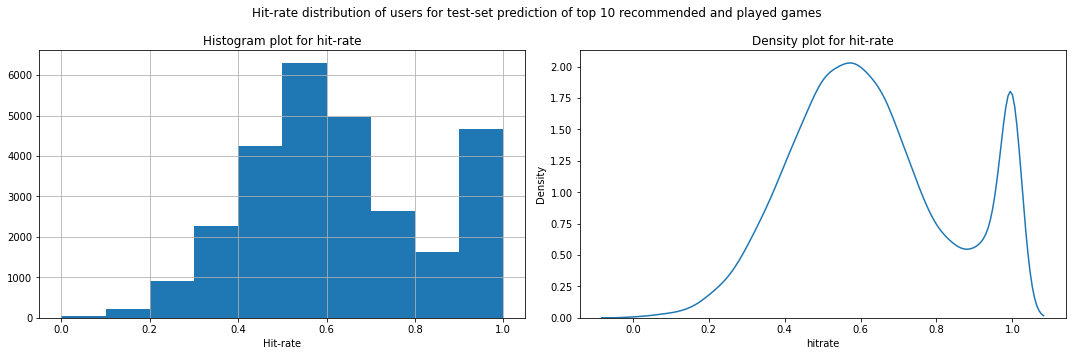

In [ ]:
f,ax = plt.subplots(1,2, figsize=(15,5))
f.suptitle('Hit-rate distribution of users for test-set prediction of top 10 recommended and played games')
hitrate_user.hitrate.hist(ax = ax[0])
ax[0].set_title("Histogram plot for hit-rate")
ax[0].set_xlabel("Hit-rate")

sns.kdeplot(hitrate_user.hitrate, ax = ax[1])
ax[1].set_title("Density plot for hit-rate")
plt.tight_layout()
plt.show()

In [ ]:
mean_hitrate = hitrate_user.hitrate.mean()
print(f"Mean hitrate :{mean_hitrate:.2f}")

Mean hitrate :0.63


Hit-rate calculated on entire dataset predictions and taking in the top 20 ranking

In [ ]:
top = 20
histories_c = []
n_fold_c = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    intr = {}
    cmodel = models.clone_model(model) 
    cmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['binary_crossentropy','mean_squared_error'], )
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    history = cmodel.fit([X_train['user'],X_train['appid']], y_train, epochs=1, validation_data = ([X_test['user'], X_test['appid']], y_test))
    
    p = cmodel.predict([X['user'],X['appid']])
    p = pd.Series(p.reshape(p.shape[0],), name="pred")
    temp = pd.concat([X.reset_index().drop(['index'],axis=1),p], axis=1)
    temp = pd.concat([temp,y.reset_index().drop(['index'],axis=1)], axis=1)
    for user in temp.user.unique():
        s1 = temp[temp.user == user].sort_values(by='hours_forever', ascending=False)[:top].appid
        s2 =temp[temp.user == user].sort_values(by='pred', ascending=False)[:top].appid
        s1 = set(s1.values)
        s2 = set(s2.values)
        hit_rate = len(s1.intersection(s2))/len(s1)
        intr[user] = hit_rate
    n_fold_c.append(intr)
    histories_c.append(history)

In [ ]:
hitrate_user_c = {}
hitrate_user_perfold_c = []
for f in n_fold_c:
    for u in f.keys():
        if u in hitrate_user_c.keys():
            hitrate_user_c[u] = (hitrate_user_c[u] + f[u]) / 2
        else:
            hitrate_user_c[u] = f[u]
    hitrate_user_perfold_c.append(np.mean(list(f.values())))
hitrate_user_c = pd.DataFrame({"user":hitrate_user_c.keys(), "hitrate":hitrate_user_c.values()})

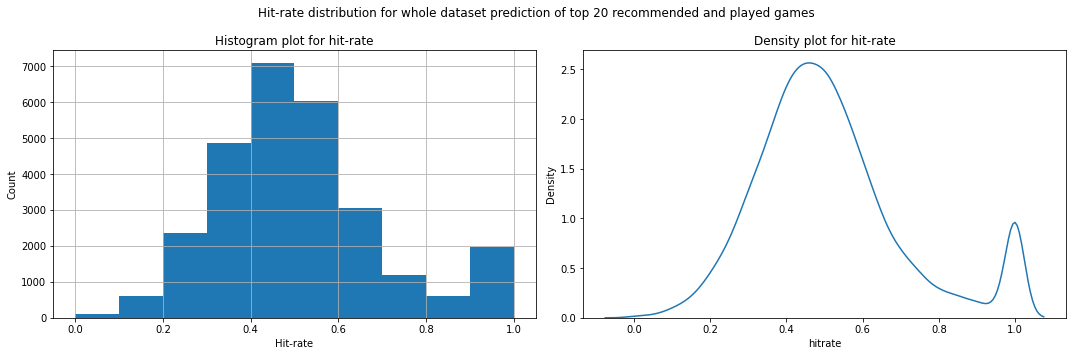

In [ ]:
f,ax = plt.subplots(1,2, figsize=(15,5))
f.suptitle('Hit-rate distribution of users for whole dataset prediction of top 20 recommended and played games')
hitrate_user_c.hitrate.hist(ax = ax[0])
ax[0].set_title("Histogram plot for hit-rate")
ax[0].set_xlabel("Hit-rate")
ax[0].set_ylabel("Count")

sns.kdeplot(hitrate_user_c.hitrate, ax = ax[1])
ax[1].set_title("Density plot for hit-rate")
plt.tight_layout()
plt.show()

In [ ]:
mean_hitrate_c = hitrate_user_c.hitrate.mean()
print(f"Mean hitrate :{mean_hitrate_c:.2f}")

Mean hitrate :0.51


**Evaluation**

Evaluation on the test-set

In [ ]:
ptab = PrettyTable()
ptab.field_names = ["K-fold Iteration", "Train Binary-Crossentropy", "Test Binary-Crossentropy", "Train MSE", "Test MSE", "Hit-rate"]
for i in range(0,4):
    a = f"{histories[i].history['binary_crossentropy'][0]:.3f}"
    b = f"{histories[i].history['val_binary_crossentropy'][0]:.3f}"
    c = f"{histories[i].history['mean_squared_error'][0]:.3f}"
    d = f"{histories[i].history['val_mean_squared_error'][0]:.5f}"
    e = f"{hitrate_user_perfold[i]:.3f}"
    ptab.add_row([i, a,b,c,d,e])
print(ptab)

+------------------+---------------------------+--------------------------+-----------+----------+----------+
| K-fold Iteration | Train Binary-Crossentropy | Test Binary-Crossentropy | Train MSE | Test MSE | Hit-rate |
+------------------+---------------------------+--------------------------+-----------+----------+----------+
|        0         |           0.076           |          0.027           |   0.017   | 0.00070  |  0.629   |
|        1         |           0.076           |          0.027           |   0.017   | 0.00070  |  0.629   |
|        2         |           0.075           |          0.027           |   0.016   | 0.00067  |  0.629   |
|        3         |           0.076           |          0.027           |   0.017   | 0.00070  |  0.628   |
+------------------+---------------------------+--------------------------+-----------+----------+----------+


**Evaluation on the whole dataset**

In [ ]:
ptab = PrettyTable()
ptab.field_names = ["K-fold Iteration", "Train Binary-Crossentropy", "Test Binary-Crossentropy", "Train MSE", "Test MSE", "Hit-rate"]
for i in range(0,5):
    a = f"{histories_c[i].history['binary_crossentropy'][0]:.3f}"
    b = f"{histories_c[i].history['val_binary_crossentropy'][0]:.3f}"
    c = f"{histories_c[i].history['mean_squared_error'][0]:.3f}"
    d = f"{histories_c[i].history['val_mean_squared_error'][0]:.5f}"
    e = f"{hitrate_user_perfold_c[i]:.3f}"
    ptab.add_row([i, a,b,c,d,e])
print(ptab)

+------------------+---------------------------+--------------------------+-----------+----------+----------+
| K-fold Iteration | Train Binary-Crossentropy | Test Binary-Crossentropy | Train MSE | Test MSE | Hit-rate |
+------------------+---------------------------+--------------------------+-----------+----------+----------+
|        0         |           0.073           |          0.027           |   0.016   | 0.00069  |  0.511   |
|        1         |           0.073           |          0.027           |   0.016   | 0.00067  |  0.513   |
|        2         |           0.074           |          0.027           |   0.016   | 0.00071  |  0.506   |
|        3         |           0.072           |          0.027           |   0.015   | 0.00069  |  0.511   |
|        4         |           0.072           |          0.027           |   0.015   | 0.00070  |  0.510   |
+------------------+---------------------------+--------------------------+-----------+----------+----------+


**Inference**

Visualizing user-embeddings with PCA

In [ ]:
users = random.choices(range(0, nusers), k = 500)
users_game_sel = users_game[users_game.user.isin(users)]
mrg = pd.merge(users_game_sel, games, on='appid', how='inner')
mrg = mrg.iloc[:,[0] + list(np.arange(13,437))]

In [ ]:
bt = []
tsum = mrg.groupby('user').sum()
for u in mrg.user:
    srt = tsum.loc[u].sort_values(ascending=False)
    idx = srt.index
    bt.append(idx[0])

mrg['best_tag'] = pd.Series(bt)
mrg = mrg[['user','best_tag']]

infer_model = Model(inputs = input_user, outputs = emb_user)
inf = infer_model.predict(mrg.user)

pca = PCA(n_components=25)
new_d = pca.fit_transform(inf.squeeze())
mrg = pd.concat([pd.DataFrame(new_d),mrg], axis=1)

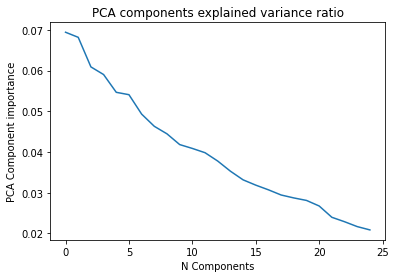

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.title("PCA components explained variance ratio")
plt.xlabel("N Components")
plt.ylabel("PCA Component importance")
plt.xticks()
plt.show()

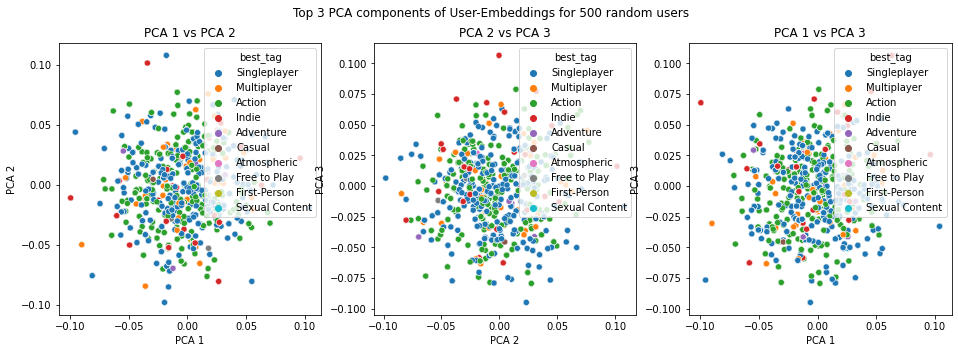

In [ ]:
f,axs = plt.subplots(1,3, figsize=(16,5))
f.suptitle("Top 3 PCA components of User-Embeddings for 500 random users")
sns.scatterplot(data = mrg, x = 0, y = 1, hue="best_tag", ax = axs[0])
axs[0].set_xlabel("PCA 1")
axs[0].set_ylabel("PCA 2")
axs[0].set_title("PCA 1 vs PCA 2")

sns.scatterplot(data = mrg, x = 1, y = 2, hue="best_tag", ax = axs[1])
axs[1].set_xlabel("PCA 2")
axs[1].set_ylabel("PCA 3")
axs[1].set_title("PCA 2 vs PCA 3")

sns.scatterplot(data = mrg, x = 0, y = 2, hue="best_tag", ax = axs[2])
axs[2].set_xlabel("PCA 1")
axs[2].set_ylabel("PCA 3")
axs[2].set_title("PCA 1 vs PCA 3")

plt.show()

Visualizing games-embeddings with PCA

In [ ]:
games_ = random.choices(range(0, ngames), k =1000)
games_ = games[['appid','genre']]
infer_model = Model(inputs = input_games, outputs = emb_games)
inf = infer_model.predict(games_['appid'])
pca = PCA(n_components=25)
new_d = pca.fit_transform(inf.squeeze())
new_d = pd.concat([pd.DataFrame(new_d), games_], axis=1)

In [ ]:
new_d = new_d[~new_d['genre'].isnull()]

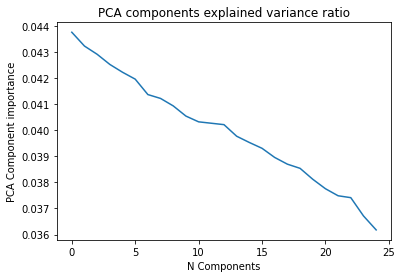

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.title("PCA components explained variance ratio")
plt.xlabel("N Components")
plt.ylabel("PCA Component importance")
plt.xticks()
plt.show()

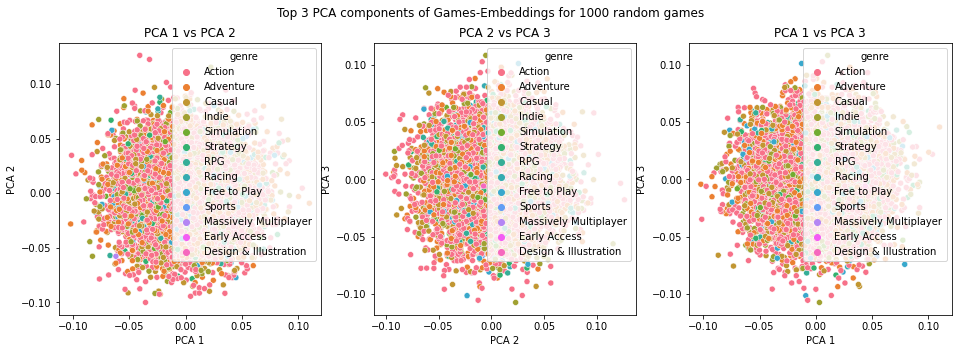

In [ ]:
f,axs = plt.subplots(1,3, figsize=(16,5))
f.suptitle("Top 3 PCA components of Games-Embeddings for 1000 random games")
sns.scatterplot(data = new_d, x = 0, y = 1, hue="genre", ax = axs[0])
axs[0].set_xlabel("PCA 1")
axs[0].set_ylabel("PCA 2")
axs[0].set_title("PCA 1 vs PCA 2")

sns.scatterplot(data = new_d, x = 1, y = 2, hue="genre", ax = axs[1])
axs[1].set_xlabel("PCA 2")
axs[1].set_ylabel("PCA 3")
axs[1].set_title("PCA 2 vs PCA 3")

sns.scatterplot(data = new_d, x = 0, y = 2, hue="genre", ax = axs[2])
axs[2].set_xlabel("PCA 1")
axs[2].set_ylabel("PCA 3")
axs[2].set_title("PCA 1 vs PCA 3")

plt.show()

### Content Boosted Collaborative filtering
- In this model, first we calculate the prediction of rating (here, hours_forever) for user for all games
- The implementation of content based recommendation is given below

In [ ]:
X = finaldf.drop(['rating', 'appid'], axis = 1)
y = finaldf[['rating']]
trainx, testx, trainy, testy = train_test_split(X,y, train_size=0.8,random_state = 22)

In [ ]:
cols = ['total_reviews', 'positive_reviews', 'negative_reviews', 'price', 'year']
scaler = StandardScaler()
scaler.fit(trainx[cols])
trainx[cols] = scaler.transform(trainx[cols])
testx[cols] = scaler.transform(testx[cols])

In [ ]:
trainy= pd.DataFrame(trainy)
testy = pd.DataFrame(testy)

In [ ]:
top1000id = pd.unique(X.users_labels)
print(len(top1000id))

1000


- Here, we have implemented the Ridge model and Random Forest model to predict the rating(hours_forever)

In [ ]:
## creating dictionaries to store different models for users.

ridge_user_model = {}
rf_user_model = {}


## Creating dictionaries to store the test MSEs.

ridge_test_score = {}
rf_test_score = {}


## Loop to go through all the users.
training_error, validation_error = [],[]
for user in top1000id:
    ## Creating x and y training variables
    user_x = trainx[trainx['users_labels'] == user].drop(['users_labels'], axis=1)
    user_y = trainy[trainx['users_labels'] == user]
    
    
    ## Create the test variables.
    user_testx = testx[testx['users_labels']==user].drop(['users_labels'], axis=1)
    user_testy = testy[testx['users_labels']==user]
    #user_testy = scaler.transform(user_testy)
    
     
   
    #Ridge
    
    ridge_model_best = Ridge(alpha=100,fit_intercept=True,normalize=True, max_iter=3000,tol=0.001,solver='lsqr',random_state=42,)
    ridge_model_best.fit(user_x, user_y)
    ridge_test_pred = ridge_model_best.predict(user_testx)
    
    ridge_test_err = mean_squared_error(ridge_test_pred, user_testy)    
    
    ridge_user_model[user] = ridge_model_best
    ridge_test_score[user] = ridge_test_err
    #print(ridge_model.coef_)
    
    
    
    rf_model = RandomForestRegressor(n_estimators=100, max_depth= 5, max_features='auto', bootstrap = True)
    rf_model.fit(user_x, user_y)
    
    rf_test_pred = rf_model.predict(user_testx)
    rf_test_err = mean_squared_error(rf_test_pred, user_testy)
        
    rf_user_model[user] = rf_model
    rf_test_score[user] = rf_test_err
    

In [ ]:
pt = PrettyTable()
pt.field_names = ["Model","Mean of MSEs","Standard Deviation"]

pt.add_row(['Ridge',round(np.mean(list(ridge_test_score.values())),4), round(np.std(list(ridge_test_score.values())),4)])

pt.add_row(['Random Forest',round(np.mean(list(rf_test_score.values())),4), round(np.std(list(rf_test_score.values())),4)])
print(pt)

+---------------+--------------+--------------------+
|     Model     | Mean of MSEs | Standard Deviation |
+---------------+--------------+--------------------+
|     Ridge     |    0.1124    |       0.1537       |
| Random Forest |    0.1091    |       0.1333       |
+---------------+--------------+--------------------+


- Here, we got the MSE for the Ridge and Random forest model 
- We are using Random Forest model for the prediction

In [ ]:
games_list = finaldf.appid.unique()
print(len(games_list))

8551


In [ ]:
games_new = games[games['appid'].isin(games_list)]
games_new.shape

(8551, 430)

In [ ]:
feats = games_new.drop(['appid'], axis = 1)

In [ ]:
cols = ['total_reviews', 'positive_reviews', 'negative_reviews', 'price', 'year']
feats[cols] = scaler.transform(feats[cols])

- This is the function to get recommendation for each user given the userid

In [ ]:
def get_recommendation(userid, recep):
    pred = rf_user_model[userid].predict(recep)
    
    return pred 

- Getting the prediction and appending it to a list so that it will be of same shape as the user_matrix 

In [ ]:
user_pred_list = []
for user in top1000id:
 
  pred = get_recommendation(user, feats)
  user_pred_list.append(pred)
  

In [ ]:
user_pred_arr = np.array(user_pred_list)
user_pred_arr.shape

(1000, 8551)

In [ ]:
# Creating a 2D matrix (user ID vs movie ID) with the ratings as elements
user_matrix = finaldf.pivot(index='users_labels', columns='appid', values='rating')


- Here, we are creating a bool matrix where there are values it will be 0 and where there are nan values it will be 1

In [ ]:
bool_mat = np.isnan(user_matrix)*1

- We are doing elementwise multiplication of bool matrix with the user prediction array so that where there are no values it will be the value of user prediction array and where there are values it will be 0, then we add both the matrix to get the user prediction matrix

In [ ]:
mult_mat = bool_mat*user_pred_arr
user_matrix = user_matrix.fillna(0.0)
user_prediction_mat = user_matrix + mult_mat
user_prediction_mat

appid,20,30,40,50,60,70,130,220,240,300,...,1877960,1888430,1891700,1901200,1902490,1911390,1922560,1926680,1948280,1959480
users_labels,,,,,,,,,,,,,,,,,,,,,
16,0.010934,0.007231,0.016438,0.007231,0.007302,0.007302,0.022804,0.005090,0.003760,0.006640,...,0.007231,0.007231,0.007231,0.007231,0.007302,0.007231,0.007231,0.104359,0.009924,0.007302
39,0.018751,0.010949,0.019870,0.010949,0.010949,0.010949,0.014752,0.011035,0.010949,0.010949,...,0.012264,0.010949,0.013196,0.010949,0.010949,0.010963,0.010949,0.011143,0.010949,0.010949
47,0.047141,0.020101,0.020935,0.020101,0.020101,0.021030,0.023493,0.023233,0.115210,1.036870,...,0.031673,0.020101,0.021590,0.020101,0.203184,0.022100,0.022100,0.031204,0.020101,0.020101
59,0.019300,0.009855,0.018789,0.017091,0.009855,0.009855,0.014093,0.018760,0.278930,0.022330,...,0.009855,0.009855,0.013460,0.033263,0.009855,0.011077,0.011523,0.358969,0.009855,0.009855
64,0.056411,0.029198,0.031472,0.026263,0.028727,0.027695,0.027344,0.025030,0.027795,0.027803,...,0.027965,0.027695,0.027695,0.026263,0.028240,0.036410,0.028724,0.026363,0.026263,0.027695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16800,0.007032,0.007001,0.024214,0.013079,0.006314,0.014380,0.024187,0.043710,0.005518,0.005558,...,0.005518,0.005518,0.006283,0.005518,0.005518,0.006392,0.005570,0.016953,0.005518,0.005518
16895,0.012666,0.006458,0.012666,0.032884,0.032884,0.032884,0.012866,0.006458,0.006588,0.007176,...,0.006458,0.006458,0.006458,0.006458,0.088277,0.007097,0.006967,0.052995,0.006458,0.006720
17003,0.019740,0.015239,0.020618,0.020969,0.017224,0.015360,0.014690,0.024267,0.014697,0.014803,...,0.014644,0.014708,0.016520,0.014720,0.014644,0.014757,0.365516,0.062588,0.388800,0.014803


- User prediction matrix is that where there are rating it will have rating and where there are no rating it take the prediction from content based recommendation system

In [ ]:
csr = csr_matrix(user_dist_matrix)

In [ ]:
similarities_sparse = cosine_similarity(csr,dense_output=False)

In [ ]:
n = [3,5,7,10,15]
nusers = csr.shape[0]
ngames = csr.shape[1]

In [ ]:
n_mse = []
n_hitrate = []
for negh in n:
    pred = np.zeros(shape=(nusers,ngames))
    iters = {}
    for user in range(0,nusers):
        p = list(np.argsort(similarities_sparse.getrow(user).toarray()[0])[::-1][:negh])
        n_vectors = np.zeros(shape=(negh,ngames))
        if user in p:
            p.remove(user)
        for i,neighbour in enumerate(p):
            n_vectors[i] = csr.getrow(neighbour).toarray()[0]
        
        pred[user] = n_vectors.mean(axis=0)
        
        played = set(list(np.argsort(csr.getrow(user).toarray()[0])[::-1][:10]))
        recom = set(list(np.argsort(pred[user])[::-1][:10]))
        hitrate = len(played.intersection(recom))/len(played)
        iters[user] = hitrate
    n_hitrate.append(iters)
    n_mse.append(np.mean((csr.toarray() -  pred)**2))

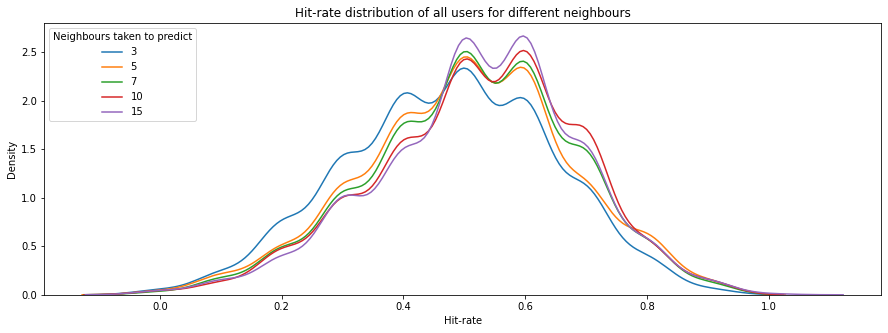

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Hit-rate distribution of all users for different neighbours")
for i in n_hitrate:
    sns.kdeplot(i.values())
plt.xlabel("Hit-rate")
plt.legend(title='Neighbours taken to predict', loc='upper left', labels=n)
plt.show()

In [ ]:
n_hitrate_by_user = np.zeros(shape=(nusers))
for hrate in n_hitrate:
    n_hitrate_by_user += list(hrate.values())
n_hitrate_by_user = n_hitrate_by_user/5

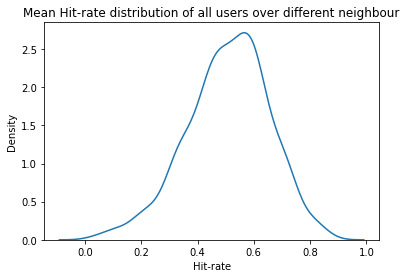

In [ ]:
sns.kdeplot(n_hitrate_by_user)
plt.title("Mean Hit-rate distribution of all users over different neighbour")
plt.xlabel("Hit-rate")
plt.show()

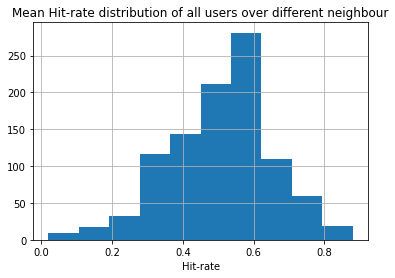

In [ ]:
pd.Series(n_hitrate_by_user).hist()
plt.title("Mean Hit-rate distribution of all users over different neighbour")
plt.xlabel("Hit-rate")
plt.show()

In [ ]:
n_hitrate_by_neigh = []
for hrate in n_hitrate:
    n_hitrate_by_neigh.append(np.mean(list(hrate.values())))

In [ ]:
ptab = PrettyTable()
ptab.field_names = ["N-Neighbours", "Mean Hit-rate", "MSE"]
for i,n_ in enumerate(n):
    a = f"{n_hitrate_by_neigh[i]:.3f}"
    b = f"{n_mse[i]:.7f}"
    
    ptab.add_row([n_, a, b])
print(ptab)

+--------------+---------------+-----------+
| N-Neighbours | Mean Hit-rate |    MSE    |
+--------------+---------------+-----------+
|      3       |     0.474     | 0.0846201 |
|      5       |     0.505     | 0.0305447 |
|      7       |     0.514     | 0.0160078 |
|      10      |     0.524     | 0.0085603 |
|      15      |     0.524     | 0.0048652 |
+--------------+---------------+-----------+


In [ ]:
def get_recom(user, sim, csr, neighbours = 5, games = 5):
    user_g = get_ugames(user, top1000users)
    rec = []
    nearest_users = np.argsort(sim.getrow(user).toarray()[0])[(-1-neighbours):-1]
    s = None
    for user in nearest_users:
        csr.getrow(user).toarray()
        if type(s)==type(None):
            s = csr.getrow(user).toarray()
        else:
            s += csr.getrow(user).toarray()
    for g in s[0].argsort()[::-1]:
        if g in user_g:
            continue
        if len(rec) == games:
            return rec
        else:
            rec.append(g)
    return rec

def get_ugames(user, top1000users):
    return top1000users[top1000users.users_labels == user].appid.values

# Dimensionality Reduction and Clustering
- Here, we are going to explore whether there are any clusters in data, so that we can proceed with some clustering based recommendation system

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

## PCA for Dimensionality Reduction

In [ ]:
X = finaldf.drop(['rating'], axis = 1)
y = finaldf[['rating']]

In [ ]:
X_clus = X.drop(['appid', 'users_labels'], axis = 1)

In [ ]:
cols = ['total_reviews', 'positive_reviews', 'negative_reviews', 'price', 'year']
scaler = StandardScaler()
X_clus[cols] = scaler.fit_transform(X_clus[cols])

In [ ]:
X_clus.shape

(652519, 429)

- We need to do dimensionality reduction by preserving the variance as much as possible, here we are targeting 90
- So we are plotting the explained variance of each principal components and its cumulative variance to observe how the variance is explained as a function principal component

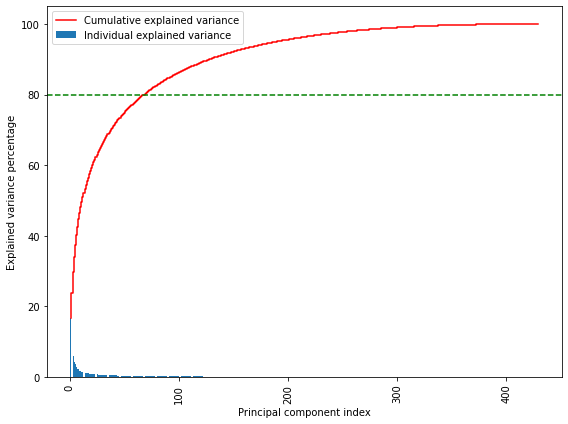

In [ ]:
pca2 = PCA()
pca2.fit(X_clus)
exp_var = pca2.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.figure(figsize = (8, 6))
plt.bar(range(1, 430), exp_var, align='center', label='Individual explained variance')
plt.step(range(1, 430), cum_exp_var, where='mid',label='Cumulative explained variance', color='red')
plt.axhline(y=80, color = 'green', linestyle = '--'  )
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(rotation = 90)
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
for idx, value in enumerate(cum_exp_var):
  if value >= 90:
    print(f"The number of  components which explains almost 90 % of variance of data = {idx+1}")
    break

The number of  components which explains almost 90 % of variance of data = 129


**Inference:**
- The green line is the plot is where 80 % of the variance is explained and the number of principal components needed for that is around 90
- We can also observe that after around 120 components the other components aren't explaining much variance
- Here we want more than 90 % variance so we are going with n components =  130


In [ ]:
pca = PCA(n_components = 130) 
X_transformed = pca.fit_transform(X_clus)
# your code here

In [ ]:
X_transformed_df = pd.DataFrame(X_transformed, columns=components)
X_transformed_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130
0,-0.040048,-0.309905,-2.258803,-0.417758,-0.657548,-0.423519,-0.812203,0.216125,-0.107734,0.024305,...,0.314147,-0.18438,-0.036145,0.200988,0.18974,0.020408,-0.275929,0.108316,-0.26763,-0.037237
1,-0.040048,-0.309905,-2.258803,-0.417758,-0.657548,-0.423519,-0.812203,0.216125,-0.107734,0.024305,...,0.314147,-0.18438,-0.036145,0.200988,0.18974,0.020408,-0.275929,0.108316,-0.26763,-0.037237
2,-0.040048,-0.309905,-2.258803,-0.417758,-0.657548,-0.423519,-0.812203,0.216125,-0.107734,0.024305,...,0.314147,-0.18438,-0.036145,0.200988,0.18974,0.020408,-0.275929,0.108316,-0.26763,-0.037237
3,-0.040048,-0.309905,-2.258803,-0.417758,-0.657548,-0.423519,-0.812203,0.216125,-0.107734,0.024305,...,0.314147,-0.18438,-0.036145,0.200988,0.18974,0.020408,-0.275929,0.108316,-0.26763,-0.037237
4,-0.040048,-0.309905,-2.258803,-0.417758,-0.657548,-0.423519,-0.812203,0.216125,-0.107734,0.024305,...,0.314147,-0.18438,-0.036145,0.200988,0.18974,0.020408,-0.275929,0.108316,-0.26763,-0.037237


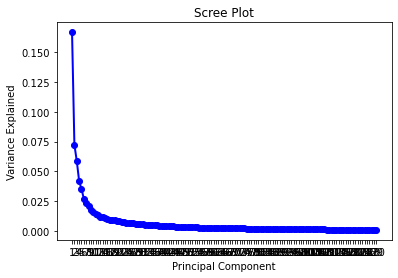

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, explained_variance_ratio, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(PC_values)
plt.show()

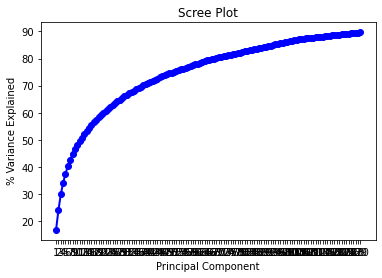

In [ ]:
var = np.cumsum(np.round(explained_variance_ratio, 3)*100)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, var, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel(' % Variance Explained')
plt.xticks(PC_values)
plt.show()

**Inference:**
- We can observe that the variance explained by first few components are much higher compared to other components 
- Since, we took n components = 130 which give more than 90 % variance we can observe that in cumulative variance plot


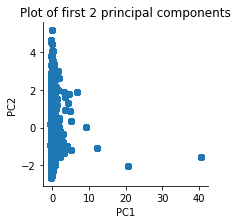

In [ ]:
sns.FacetGrid(X_transformed_df).map(plt.scatter, 'PC1', 'PC2').add_legend()
plt.title("Plot of first 2 principal components")
plt.show()


**Inference:**
- We can observe few points random pointes and some blob and we can't say whether there are clusters or so. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f31d45cf990>],
      dtype=object)

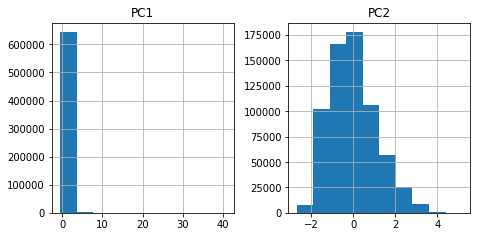

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
fig, axes = plt.subplots(1, 2)

X_transformed_df.hist('PC1', ax=axes[0])
X_transformed_df.hist('PC2', ax=axes[1])


**Inference:**
- We can observe that the PC1 is skewed and PC2 is almost symmetrically distributed 

**Finding the optimal K from inertia plot**

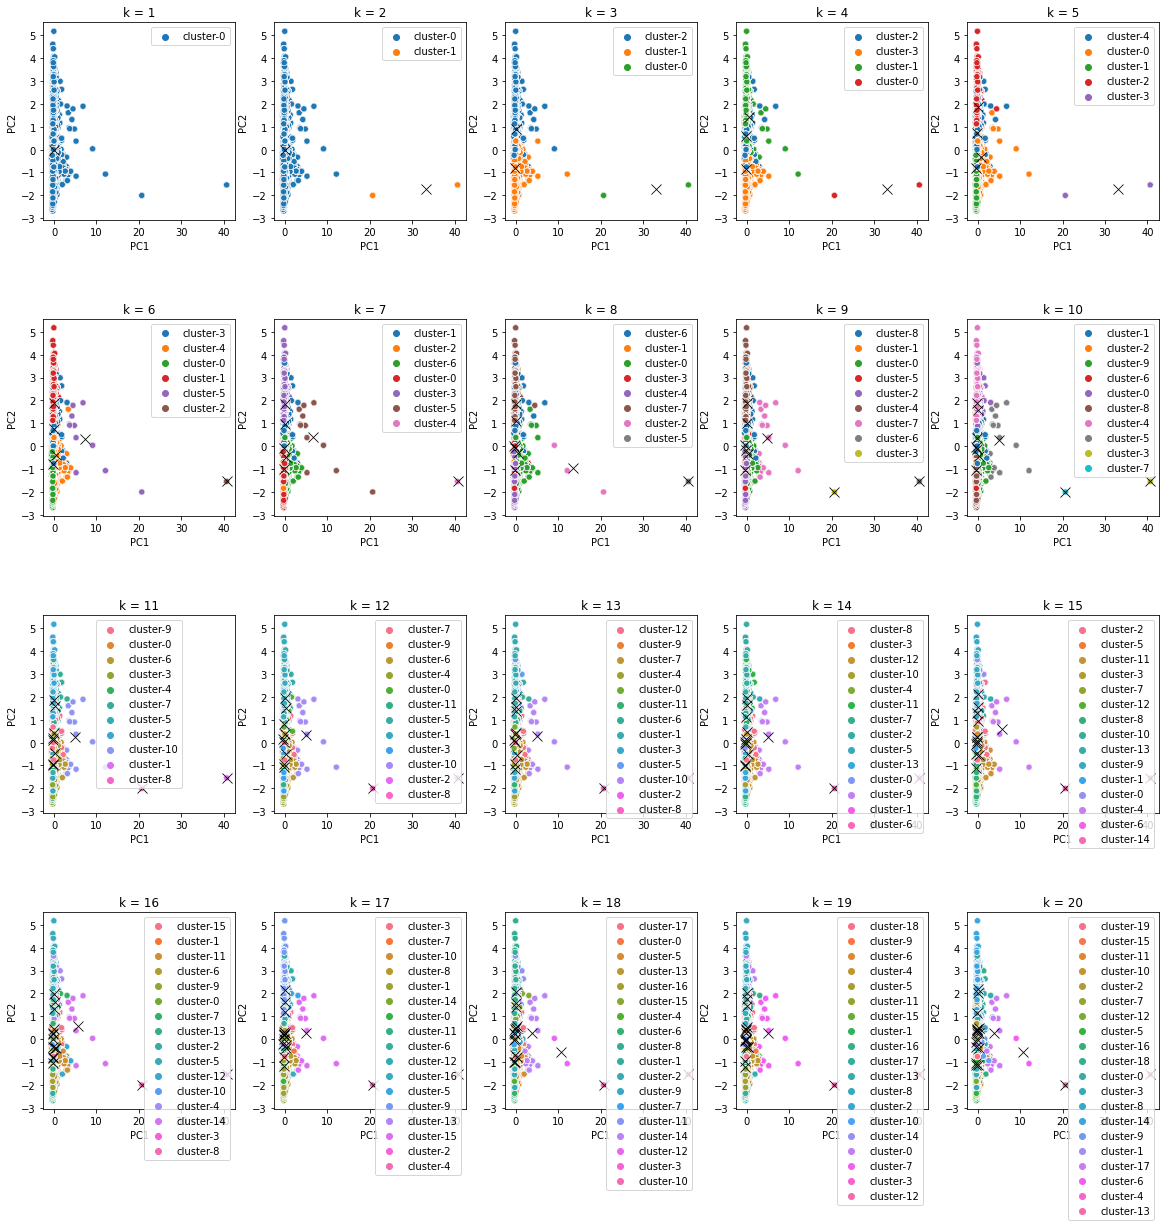

In [ ]:
k_list = np.arange(1, 21)
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
inertias = []
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_transformed_df)
    ssd = kmeans.inertia_
    inertias.append(ssd)
    ax = fig.add_subplot(4, 5, i)
    #adding text to the axis ie each of the plots
    ax.set_title(f"k = {k}")
   
    
    sns.scatterplot(x = X_transformed_df.iloc[:,0], y = X_transformed_df.iloc[:,1], hue=["cluster-{}".format(x) for x in labels])
    sns.scatterplot(x = kmeans.cluster_centers_[:,0], y = kmeans.cluster_centers_[:,1], marker='x', color='black', s=100)
    i += 1

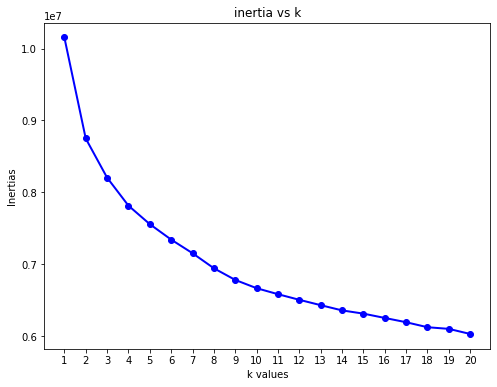

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(k_list, inertias, 'o-', linewidth=2, color='blue')
plt.title('inertia vs k')
plt.xlabel('k values')
plt.ylabel('Inertias')
plt.xticks(k_list)
plt.show()

- Here we can choose k in range 5-16
- We are chossing Choosing k = 10
- Fitting the KMeans for the optimal k

In [ ]:
kmeans = KMeans(n_clusters = 10, random_state=42)
kmeans.fit(X_transformed_df)

KMeans(n_clusters=10, random_state=42)

In [ ]:
X_transformed_df['cluster']=kmeans.labels_

Text(0.5, 1.0, 'Courses with PCA decompostion')

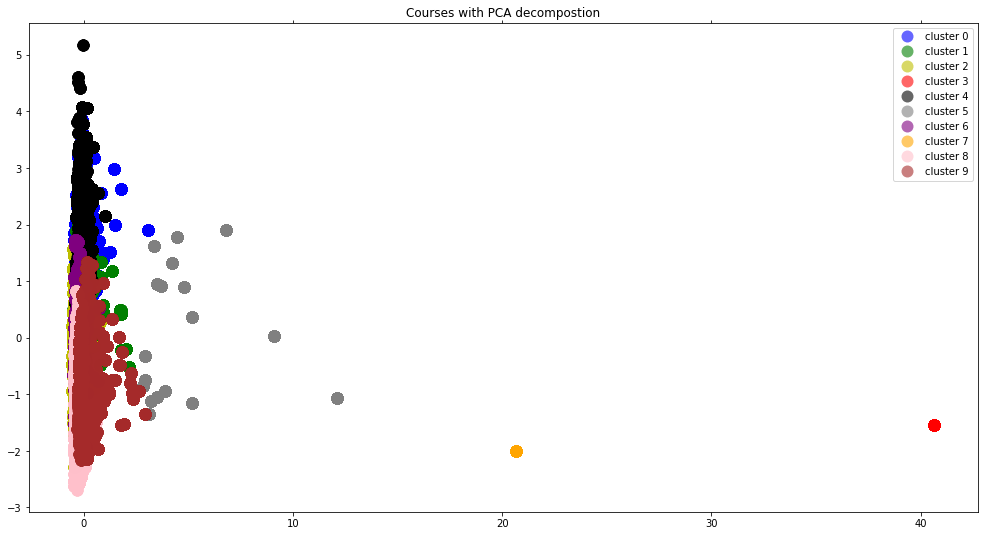

In [ ]:
groups = X_transformed_df.groupby('cluster')
cluster_colors=['b', 'g', 'y','r', 'k', 'grey', 'purple','orange', 'pink', 'brown']
fig, ax = plt.subplots(figsize=(17, 9)) 
for name in np.arange(len(X_transformed_df['cluster'].unique())):
    temp=X_transformed_df[X_transformed_df['cluster']==name]
    ax.plot(temp.PC1, temp.PC2, marker='o', linestyle='', ms=12, 
        label='cluster '+str(name), 
        color=cluster_colors[name], 
        mec='none', alpha=0.6)
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', bottom='off', top='off', labelbottom='off')
ax.legend(numpoints=1) 
plt.title('Courses with PCA decompostion')

**Inference:**
- We can observe that the lumped part which we saw in PCA components plot now seems like vertically separated clusters 
- We can do 3 component K-Means and visualize whether we can separate the clusters

In [ ]:
X_kmeans_3 = X_transformed_df[['PC1','PC2','PC3']]
X_kmeans_3.head(2)

,PC1,PC2,PC3
0,-0.040048,-0.309905,-2.258803
1,-0.040048,-0.309905,-2.258803


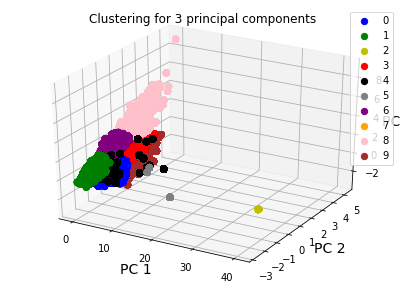

In [ ]:
kmeans_3 = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(X_kmeans_3)
centers = np.array(kmeans.cluster_centers_)
Xax = X_kmeans_3['PC1'].values
Yax = X_kmeans_3['PC2'].values
Zax = X_kmeans_3['PC3'].values
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
cluster_colors=['b', 'g', 'y','r', 'k', 'grey', 'purple','orange', 'pink', 'brown']

fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix=np.where(labels==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cluster_colors[l], s=40,  label= l)
# for loop ends
ax.set_xlabel("PC 1", fontsize=14)
ax.set_ylabel("PC 2", fontsize=14)
ax.set_zlabel("PC 3", fontsize=14)
ax.set_title("Clustering for 3 principal components")

ax.legend()
plt.show()

**Inference:**
- Here, we can observe almost 8 clusters separately out of the 10 clusters
- We can do a paiwise plot to see which components are important in separating the clusters

In [ ]:
labels_df = pd.DataFrame(labels.tolist(), columns=['label'])
df_pair = pd.concat([X_kmeans_3, labels_df], axis =1)
df_pair.head(2)

,PC1,PC2,PC3,label
0,-0.040048,-0.309905,-2.258803,0
1,-0.040048,-0.309905,-2.258803,0


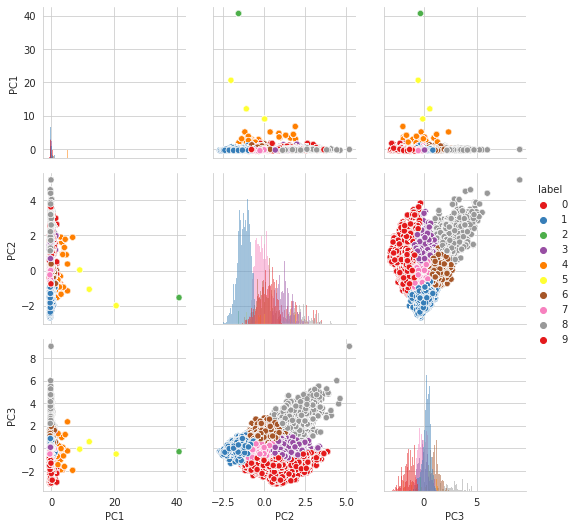

In [ ]:
sns.set_style("whitegrid")
g = sns.PairGrid(df_pair, hue = 'label', palette=sns.color_palette("Set1", n_colors=10))
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

**Inference:**
- We can observe that PC1 and PC2 separates the clusters 2, 4, 5
- PC2 and PC3 separates almost all other clusters
- We can conclude that we can clearly cluster our data and the recommendation systems can be used according to clusters. 

## Cluster Based Content Boosted Collaborative Filtering

In [ ]:
users = finaldf[['users_labels']]
X_trans = pd.concat([X_transformed_df, users], axis = 1)

X_trans.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,cluster,users_labels
0,-0.040048,-0.309905,-2.258803,-0.417757,-0.657548,-0.423519,-0.812203,0.216124,-0.107736,0.024304,...,-0.044439,-0.255328,-0.266874,0.179925,-0.258876,0.001031,-0.148481,0.092253,0,150
1,-0.040048,-0.309905,-2.258803,-0.417757,-0.657548,-0.423519,-0.812203,0.216124,-0.107736,0.024304,...,-0.044439,-0.255328,-0.266874,0.179925,-0.258876,0.001031,-0.148481,0.092253,0,653
2,-0.040048,-0.309905,-2.258803,-0.417757,-0.657548,-0.423519,-0.812203,0.216124,-0.107736,0.024304,...,-0.044439,-0.255328,-0.266874,0.179925,-0.258876,0.001031,-0.148481,0.092253,0,1110
3,-0.040048,-0.309905,-2.258803,-0.417757,-0.657548,-0.423519,-0.812203,0.216124,-0.107736,0.024304,...,-0.044439,-0.255328,-0.266874,0.179925,-0.258876,0.001031,-0.148481,0.092253,0,1701
4,-0.040048,-0.309905,-2.258803,-0.417757,-0.657548,-0.423519,-0.812203,0.216124,-0.107736,0.024304,...,-0.044439,-0.255328,-0.266874,0.179925,-0.258876,0.001031,-0.148481,0.092253,0,2039


In [ ]:
clust_list = X_trans.cluster.unique()
clust_list

array([0, 5, 3, 2, 4, 7, 1, 9, 6, 8], dtype=int32)

In [ ]:
## creating dictionaries to store different models for users.
lass_user_model = {}
ridge_clust_model = {}
rf_clust_model = {}
lr_user_model = {}

## Creating dictionaries to store the test MSEs.
lass_test_score = {}
ridge_test_score = {}
rf_test_score = {}
lr_test_score = {}

## Loop to go through all the users.
training_error, validation_error = [],[]
for clust in clust_list:
    ## Creating x and y training variables
    clust_x = trainx[trainx['cluster'] == clust].drop(['users_labels', 'cluster'], axis=1)
    clust_y = trainy[trainx['cluster'] == clust]
    
    #scaler = StandardScaler()
    #clust_y = scaler.fit_transform(clust_y)
    
    
    
    ## Create the test variables.
    clust_testx = testx[testx['cluster']==clust].drop(['users_labels', 'cluster'], axis=1)
    clust_testy = testy[testx['cluster']==clust]
    #clust_testy = scaler.transform(clust_testy)
    
    
    
   
    #Ridge
    
    ridge_model_best = Ridge(alpha=100,fit_intercept=True,normalize=True, max_iter=3000,tol=0.001,solver='lsqr',random_state=42,)
    ridge_model_best.fit(clust_x, clust_y)
    ridge_test_pred = ridge_model_best.predict(clust_testx)
    
    ridge_test_err = mean_squared_error(ridge_test_pred, clust_testy)    
    
    ridge_clust_model[clust] = ridge_model_best
    ridge_test_score[clust] = ridge_test_err
    #print(ridge_model.coef_)
    
    
    
    rf_model = RandomForestRegressor(n_estimators=100, max_depth= 5, max_features='auto', bootstrap = True)
    rf_model.fit(clust_x, clust_y)
    
    rf_test_pred = rf_model.predict(clust_testx)
    rf_test_err = mean_squared_error(rf_test_pred, clust_testy)
        
    rf_clust_model[clust] = rf_model
    rf_test_score[clust] = rf_test_err
    

In [ ]:
pt = PrettyTable()
pt.field_names = ["Model","Mean of MSEs","Standard Deviation"]

pt.add_row(['Ridge',round(np.mean(list(ridge_test_score.values())),4), round(np.std(list(ridge_test_score.values())),4)])

pt.add_row(['Random Forest',round(np.mean(list(rf_test_score.values())),4), round(np.std(list(rf_test_score.values())),4)])
print(pt)

+---------------+--------------+--------------------+
|     Model     | Mean of MSEs | Standard Deviation |
+---------------+--------------+--------------------+
|     Ridge     |    0.6918    |       1.0658       |
| Random Forest |    0.6828    |       1.0641       |
+---------------+--------------+--------------------+


In [ ]:
def get_recommendation(clust_id, recep):
    pred = rf_clust_model[clust_id].predict(recep)
    
    return pred 

In [ ]:
user_pred_list = []
for user in top1000id:
   clusters = X_trans[X_trans['users_labels']==user]['cluster'].tolist()
   #cluster = max(set(clusters), key = clusters.count)
   clust_dict = {x:clusters.count(x) for x in clusters}
   clusters_pred_list = []
   for clust in clust_dict.keys():
      pred = get_recommendation(clust, feats)
      for i in range(clust_dict[clust]):
        clusters_pred_list.append(pred)
   pred_list = np.array(clusters_pred_list)
  
   user_pred_list.append(pred_list.mean(axis=0))
  

In [ ]:
# Creating a 2D matrix (user ID vs movie ID) with the ratings as elements
user_matrix = finaldf.pivot(index='users_labels', columns='appid', values='rating')


In [ ]:
bool_mat = np.isnan(user_matrix)*1


In [ ]:
mult_mat = bool_mat*user_pred_arr
user_matrix = user_matrix.fillna(0.0)
user_prediction_mat = user_matrix + mult_mat
user_prediction_mat

appid,20,30,40,50,60,70,130,220,240,300,...,1877960,1888430,1891700,1901200,1902490,1911390,1922560,1926680,1948280,1959480
users_labels,,,,,,,,,,,,,,,,,,,,,
16,0.076818,0.056983,0.067701,0.081253,0.045284,0.053594,0.117348,0.005090,0.003760,0.006640,...,0.052837,0.047152,0.057754,0.052089,0.044849,0.047317,0.055564,0.064638,0.050800,0.054380
39,0.081883,0.055899,0.067159,0.085122,0.044807,0.053419,0.121167,0.067483,0.067249,0.047736,...,0.052146,0.044899,0.055855,0.049016,0.044590,0.047285,0.049461,0.068161,0.048959,0.049053
47,0.082273,0.054143,0.065856,0.090005,0.043706,0.052618,0.123004,0.073819,0.115210,1.036870,...,0.050166,0.043141,0.054484,0.047005,0.043467,0.046110,0.046376,0.070032,0.047037,0.046191
59,0.083108,0.054983,0.070122,0.088239,0.044766,0.052668,0.131315,0.018760,0.278930,0.022330,...,0.050942,0.044715,0.057580,0.049017,0.044467,0.047078,0.048470,0.064359,0.048079,0.048149
64,0.082787,0.056219,0.068729,0.086386,0.045329,0.053788,0.125001,0.025030,0.068762,0.047719,...,0.052155,0.045391,0.056867,0.049466,0.045092,0.047654,0.049766,0.067257,0.049089,0.049135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16800,0.083148,0.069069,0.063916,0.124143,0.061556,0.063104,0.092660,0.043710,0.067953,0.069630,...,0.060009,0.061292,0.063048,0.063345,0.060533,0.061021,0.064493,0.110909,0.062035,0.077503
16895,0.091687,0.078783,0.076644,0.098958,0.063059,0.078814,0.110375,0.110293,0.077421,0.066376,...,0.068937,0.065678,0.066847,0.066387,0.062067,0.064594,0.078755,0.098499,0.067910,0.070235
17003,0.104051,0.088732,0.085943,0.123416,0.076852,0.080690,0.117040,0.142176,0.090666,0.081029,...,0.076592,0.078735,0.077524,0.077595,0.074978,0.078448,0.086248,0.115403,0.388800,0.091300


In [ ]:
user_prediction_mat = user_prediction_mat.sub(user_prediction_mat.mean(axis=1), axis=0)

In [ ]:
user_dist_matrix = 1 - user_prediction_mat.T.corr()
user_dist_matrix

users_labels,16,39,47,59,64,66,73,79,83,124,...,16377,16445,16670,16694,16695,16800,16895,17003,17069,17212
users_labels,,,,,,,,,,,,,,,,,,,,,
16,0.000000,0.905295,0.999086,0.884903,0.800699,0.891607,0.684159,0.757979,0.440454,0.141749,...,0.854006,0.909161,0.872708,0.901222,0.437990,0.895776,0.973496,0.880326,0.160012,0.280334
39,0.905295,0.000000,0.963019,0.916962,0.720629,0.924041,0.941644,0.867065,0.884286,0.893649,...,0.894049,0.719596,0.948980,0.830299,0.685105,0.910275,0.935290,0.890029,0.889185,0.918393
47,0.999086,0.963019,0.000000,1.047208,0.974563,0.956372,0.994866,0.998143,0.983910,1.008543,...,0.957058,0.974116,0.979226,0.966888,0.993229,0.946349,0.939695,0.959124,0.941100,0.957288
59,0.884903,0.916962,1.047208,0.000000,0.790449,0.928667,0.937822,0.965587,0.933239,0.872988,...,0.913007,0.950368,0.916545,0.933012,0.927529,0.934972,1.008686,0.922053,0.916536,0.934522
64,0.800699,0.720629,0.974563,0.790449,0.000000,0.712895,0.838460,0.846763,0.703993,0.776588,...,0.760168,0.733194,0.840829,0.838256,0.859597,0.823163,0.929467,0.822503,0.780087,0.826646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16800,0.895776,0.910275,0.946349,0.934972,0.823163,0.900972,0.928696,0.934896,0.889248,0.877442,...,0.831513,0.888554,0.920289,0.862597,0.893679,0.000000,0.853792,0.768816,0.837031,0.895621
16895,0.973496,0.935290,0.939695,1.008686,0.929467,0.956859,0.944483,0.949372,0.943397,0.978401,...,0.955392,0.839966,0.957963,0.858436,0.953947,0.853792,0.000000,0.941499,0.923241,0.838740
17003,0.880326,0.890029,0.959124,0.922053,0.822503,0.902242,0.921033,0.951026,0.913945,0.872442,...,0.841726,0.882244,0.896484,0.868292,0.892305,0.768816,0.941499,0.000000,0.842668,0.881410


In [ ]:
csr = csr_matrix(user_dist_matrix)

In [ ]:
similarities_sparse = cosine_similarity(csr,dense_output=False)

In [ ]:
n = [3,5,7,10,15]

In [ ]:
n = [3,5,7,10,15]
nusers = csr.shape[0]
ngames = csr.shape[1]

In [ ]:
n_mse = []
n_hitrate = []
for negh in n:
    pred = np.zeros(shape=(nusers,ngames))
    iters = {}
    for user in range(0,nusers):
        p = list(np.argsort(similarities_sparse.getrow(user).toarray()[0])[::-1][:negh])
        n_vectors = np.zeros(shape=(negh,ngames))
        if user in p:
            p.remove(user)
        for i,neighbour in enumerate(p):
            n_vectors[i] = csr.getrow(neighbour).toarray()[0]
        
        pred[user] = n_vectors.mean(axis=0)
        
        played = set(list(np.argsort(csr.getrow(user).toarray()[0])[::-1][:10]))
        recom = set(list(np.argsort(pred[user])[::-1][:10]))
        hitrate = len(played.intersection(recom))/len(played)
        iters[user] = hitrate
    n_hitrate.append(iters)
    n_mse.append(np.mean((csr.toarray() -  pred)**2))

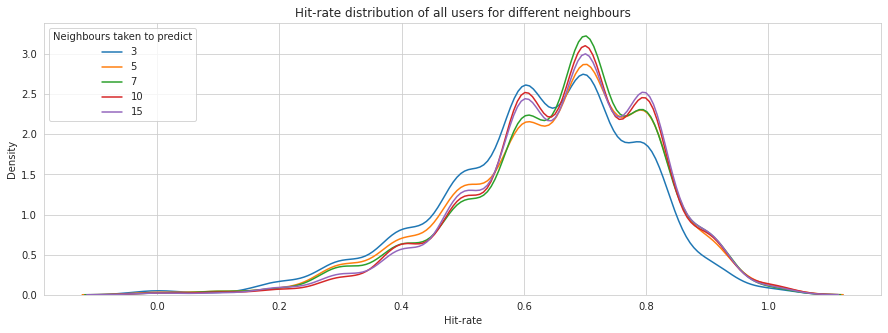

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Hit-rate distribution of all users for different neighbours")
for i in n_hitrate:
    sns.kdeplot(i.values())
plt.xlabel("Hit-rate")
plt.legend(title='Neighbours taken to predict', loc='upper left', labels=n)
plt.show()

In [ ]:
n_hitrate_by_user = np.zeros(shape=(nusers))
for hrate in n_hitrate:
    n_hitrate_by_user += list(hrate.values())
n_hitrate_by_user = n_hitrate_by_user/5

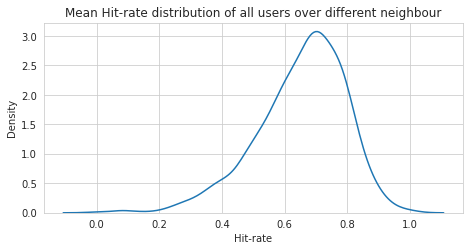

In [ ]:
sns.kdeplot(n_hitrate_by_user)
plt.title("Mean Hit-rate distribution of all users over different neighbour")
plt.xlabel("Hit-rate")
plt.show()

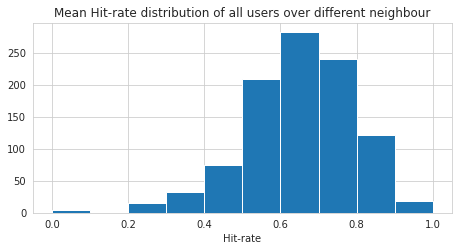

In [ ]:
pd.Series(n_hitrate_by_user).hist()
plt.title("Mean Hit-rate distribution of all users over different neighbour")
plt.xlabel("Hit-rate")
plt.show()

In [ ]:
n_hitrate_by_neigh = []
for hrate in n_hitrate:
    n_hitrate_by_neigh.append(np.mean(list(hrate.values())))

In [ ]:
ptab = PrettyTable()
ptab.field_names = ["N-Neighbours", "Mean Hit-rate", "MSE"]
for i,n_ in enumerate(n):
    a = f"{n_hitrate_by_neigh[i]:.3f}"
    b = f"{n_mse[i]:.7f}"
    
    ptab.add_row([n_, a, b])
print(ptab)

+--------------+---------------+-----------+
| N-Neighbours | Mean Hit-rate |    MSE    |
+--------------+---------------+-----------+
|      3       |     0.625     | 0.0758733 |
|      5       |     0.651     | 0.0276781 |
|      7       |     0.659     | 0.0145736 |
|      10      |     0.664     | 0.0079142 |
|      15      |     0.664     | 0.0045461 |
+--------------+---------------+-----------+


**Inference:**
- Using the cluster based content boosted collaborative filtering we got a hit rate of around 0.66 which means around the 5 games recommendation the user have played atleast 3 games which is pretty good.

# Conclusion and Inference
- **Performance:** 0.51 hit-rate is decent progress but it tells us that we are not able to make models fully personalizable.
- **Best Model:** 
   - base model : user-user based filtering (0.41 hit-rate)
   - complex model: Matrix factorization and content-boosted  filtering (0.51 hit-rate)

- **Evaluation Metric:** MSE can be used as loss function but to interpret results, we can not rely on mse. Hit-rate alone can’t explain the model.
- **Online Evaluation:** Our system currently only uses past user’s data, so we haven’t incorporated things like new games released, trends in community etc.






# Improvements
- Variety of user’s data: We can add variety of users profiles to the dataset. Use steam API to get user’s profile information. Also use other models in content boosted models.
- Use other evaluating Metrics: Currently we only used hit-rate to evaluate model performance, we can user ranked hit-rate, novelty etc. metrics.
- Game related features:It will be good if we get more game related data like length of the game or story line of the game, since the content boosted filtering when used alone wasn’t giving good results  
- Cluster Based Models: We can find the content based prediction from transformed data exploiting the cluster information and also use other cluster based models




#References
1. G. Özbal, H. Karaman and F. N. Alpaslan, "A Content-Boosted Collaborative Filtering Approach for Movie Recommendation Based on Local and Global Similarity and Missing Data Prediction," in The Computer Journal, vol. 54, no. 9, pp. 1535-1546, Sept. 2011, doi: 10.1093/comjnl/bxr001.
2. https://medium.com/fnplus/evaluating-recommender-systems-with-python-code-ae0c370c90be